In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from functools import reduce
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.patches as mpatches
import warnings
import random
warnings.filterwarnings("ignore")

Below are sections **Data Cleaning**, **Dimension Reduction**, **XGBoost Regression**, **Ridge Regression**

## Data Cleaning

In [2]:
class Data():
    def __init__(self, dfs):
        self.original_dfs = dfs
        self.dfs = dfs
        self.cleaned = False
        self.output = None
        
    def clean(self):
        if self.cleaned:
            return
        for i in range(len(self.dfs)):
            self.dfs[i] = self.dfs[i][self.dfs[i]["availability_30"] > 0]
            self.dfs[i]['occupancy_rate'] =(30 - self.dfs[i]['availability_30']) / 30
            self.dfs[i]["price"] = self.dfs[i]["price"].apply(lambda x: float(x.replace(',','')[1:]))

        merged_df = reduce(lambda left,right: pd.merge(left, right[['id', 'price', 'occupancy_rate']],on='id', how = 'inner', suffixes=('_x', '_y')), self.dfs)
        price_demand = merged_df[['id','price_x', 'price_y', 'occupancy_rate_x', 'occupancy_rate_y']]
        price_demand.columns = ['id','price_1','price_2','price_3','price_4', 'demand_1', 'demand_2', 'demand_3', 'demand_4']
        price_demand = price_demand.merge(df1[['id', 'reviews_per_month']], on='id', how = 'inner').dropna()
        price_demand['demand'] = 1/4*(price_demand['demand_1'] + price_demand['demand_2'] + price_demand['demand_3'] + price_demand['demand_4'])
        price_demand['price'] = 1/4*(price_demand['price_1'] + price_demand['price_2'] + price_demand['price_3'] + price_demand['price_4'])
        df_21 = price_demand.drop(['price_1', "price_2", "price_3", "price_4", 'demand_1', "demand_2", "demand_3", "demand_4"], axis=1).merge(df1[["id", "neighbourhood_cleansed", "bedrooms", "beds", "room_type", "minimum_nights", "amenities", "property_type", "listing_url", 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', "host_since", "calculated_host_listings_count", "accommodates"]], how = 'inner', on=['id'])
        df_21 = df_21[df_21['minimum_nights'] <= 100]
        df_21 = df_21[df_21['demand'] > 0]
        self.output = df_21
        self.dfs = self.original_dfs
        
        
    def add(self, name, func):
        self.output[name] = func(self.output)
        return
    
    def get(self):
        return self.output
    
    def original(self):
        return self.original_dfs
    
    def dropna(self, columns):
        self.output = self.output.dropna(subset=columns)
        return

In [3]:
df1 = pd.read_csv('Data/listings3.csv')
df2 = pd.read_csv('Data/listings6.csv')
df3 = pd.read_csv('Data/listings9.csv')
df4 = pd.read_csv('Data/listings12.csv')
dfs = [df1, df2, df3, df4]


In [4]:
data = Data(dfs)

In [5]:
data.clean()
data.add("price_per_person", lambda x: x['price']/x['accommodates'])
data.dropna(['room_type', "price_per_person", "review_scores_rating", "accommodates", "room_type"])

In [6]:
df = data.get()

In [7]:
df['log_demand'] = np.log((df['demand'])/(1-df['demand']))

<AxesSubplot:>

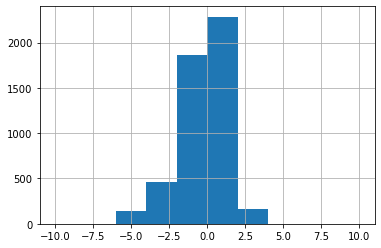

In [8]:
df.replace([np.inf, -np.inf], -50, inplace=True)
df['log_demand'].hist(range=(-10,10))

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [10]:
df = data.get()

In [11]:
df = df.dropna()

In [12]:
df.columns

Index(['id', 'reviews_per_month', 'demand', 'price', 'neighbourhood_cleansed',
       'bedrooms', 'beds', 'room_type', 'minimum_nights', 'amenities',
       'property_type', 'listing_url', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'host_since',
       'calculated_host_listings_count', 'accommodates', 'price_per_person',
       'log_demand'],
      dtype='object')

In [15]:
len(df.columns)

24

#### Zillow Housing data

In [16]:
import geopy

In [17]:
neighborhood_location = df1.groupby('neighbourhood_cleansed').mean()[['longitude', 'latitude']]

In [18]:
neighborhood_location = np.round(neighborhood_location[['longitude','latitude']], 5)

In [19]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    if 'postcode' in location.raw['address'].keys():
        return location.raw['address']['postcode']
    else:
        return 0


geolocator = geopy.Nominatim(user_agent='Jiayang_Nie')

zipcodes = neighborhood_location.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')

In [20]:
zipcodes['Agua Dulce'] = '91390'
zipcodes['Angeles Crest'] = '91011'
zipcodes['Ridge Route'] = '93225'
zipcodes['Tujunga Canyons'] = '91042'
zipcodes['Unincorporated Catalina Island'] = '90704'
zipcodes['Unincorporated Santa Susana Mountains'] = '93063'
zipcodes['Leona Valley'] = '93551'

In [21]:
zipcodes = zipcodes.apply(lambda x: x[0:5]).astype(int)

In [22]:
zipcodes = zipcodes.to_frame().reset_index()
zipcodes.columns = ['neighbourhood_cleansed', 'zipcode']

In [23]:
zipcodes

neighbourhood_cleansed  zipcode
0                    Acton    93510
1          Adams-Normandie    90007
2             Agoura Hills    91301
3               Agua Dulce    91390
4                 Alhambra    91801
..                     ...      ...
258            Willowbrook    90059
259             Wilmington    90744
260         Windsor Square    90004
261               Winnetka    91306
262         Woodland Hills    91364

[263 rows x 2 columns]

In [24]:
df = pd.merge(df, zipcodes, on = 'neighbourhood_cleansed')

In [25]:
one_bed = pd.read_csv("Data/zillow_1bed.csv")
two_bed = pd.read_csv("Data/zillow_2bed.csv")
three_bed = pd.read_csv("Data/zillow_3bed.csv")
four_bed = pd.read_csv("Data/zillow_4bed.csv")
five_bed = pd.read_csv("Data/zillow_5bed.csv")

In [26]:
def look_for(row):
    nbeds = row['bedrooms']
    zipcode = row['zipcode']
    if nbeds == 1:
        toReturn = one_bed[one_bed['RegionID'] == zipcode]['2021-12-31']
    elif nbeds == 2:
        toReturn = two_bed[two_bed['RegionID'] == zipcode]['2021-12-31']
    elif nbeds == 3:
        toReturn = three_bed[three_bed['RegionID'] == zipcode]['2021-12-31']
    elif nbeds == 4:
        toReturn = four_bed[four_bed['RegionID'] == zipcode]['2021-12-31']
    else:
        toReturn = five_bed[five_bed['RegionID'] == zipcode]['2021-12-31']
    while toReturn.empty:
        zipcode += 1
        if nbeds == 1:
            toReturn = one_bed[one_bed['RegionID'] == zipcode]['2021-12-31']
        elif nbeds == 2:
            toReturn = two_bed[two_bed['RegionID'] == zipcode]['2021-12-31']
        elif nbeds == 3:
            toReturn = three_bed[three_bed['RegionID'] == zipcode]['2021-12-31']
        elif nbeds == 4:
            toReturn = four_bed[four_bed['RegionID'] == zipcode]['2021-12-31']
        else:
            toReturn = five_bed[five_bed['RegionID'] == zipcode]['2021-12-31']
    return toReturn.iloc[0]

a = df.apply(look_for, axis=1)
            
            
            

In [27]:
df['housing_price'] = a

## Dimension Reduction

We performed dimension reduction using principal component analysis to reduce the time and storage space required. It also helps remove multi-collinearity which improves the interpretation of the parameters of the machine learning model. We one encoded the variable property type and reduced the dimensionality of the amenities column.

In [28]:
import tensorflow as tf
from tensorflow.keras import layers
from gensim.models import Word2Vec, KeyedVectors
from spacy.lang.en import English

In [29]:
from sklearn.decomposition import PCA
from prince import MCA

In [30]:
enc_ohe = OneHotEncoder()
enc_ohe.fit(df[["property_type"]])
property_types = pd.DataFrame(enc_ohe.transform(df[["property_type"]]).toarray(), columns=enc_ohe.get_feature_names(['property_type']))

In [31]:
property_types

property_type_Barn  property_type_Boat  property_type_Camper/RV  \
0                    0.0                 0.0                      0.0   
1                    0.0                 0.0                      0.0   
2                    0.0                 0.0                      0.0   
3                    0.0                 0.0                      0.0   
4                    0.0                 0.0                      0.0   
...                  ...                 ...                      ...   
4275                 0.0                 0.0                      0.0   
4276                 0.0                 0.0                      0.0   
4277                 0.0                 0.0                      0.0   
4278                 0.0                 0.0                      0.0   
4279                 0.0                 0.0                      0.0   

      property_type_Castle  property_type_Earth house  \
0                      0.0                        0.0   
1                      0.0                        0.0   
2                      0.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        0.0   
...                    ...                        ...   
4275                   0.0                        0.0   
4276                   0.0                        0.0   
4277                   0.0                        0.0   
4278                   0.0                        0.0   
4279                   0.0                        0.0   

      property_type_Entire apartment  property_type_Entire bungalow  \
0                                0.0                            0.0   
1                                0.0                            1.0   
2                                0.0                            0.0   
3                                0.0                            1.0   
4                                0.0                            0.0   
...                              ...                            ...   
4275                             0.0                            0.0   
4276                             0.0                            0.0   
4277                             0.0                            0.0   
4278                             0.0                            0.0   
4279                             0.0                            0.0   

      property_type_Entire cabin  property_type_Entire condominium  \
0                            0.0                               0.0   
1                            0.0                               0.0   
2                            0.0                               0.0   
3                            0.0                               0.0   
4                            0.0                               0.0   
...                          ...                               ...   
4275                         0.0                               0.0   
4276                         0.0                               0.0   
4277                         0.0                               0.0   
4278                         0.0                               0.0   
4279                         0.0                               0.0   

      property_type_Entire cottage  ...  \
0                              0.0  ...   
1                              0.0  ...   
2                              0.0  ...   
3                              0.0  ...   
4                              0.0  ...   
...                            ...  ...   
4275                           0.0  ...   
4276                           0.0  ...   
4277                           0.0  ...   
4278                           0.0  ...   
4279                           0.0  ...   

      property_type_Shared room in guesthouse  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                    

In [32]:
mca_property = MCA(n_components = 10, n_iter = 100, random_state = 101)
mca_property.fit(property_types)
property_mca = mca_property.transform(property_types)
property_mca.head()

0         1         2         3         4         5         6  \
0 -0.126122 -0.927554 -0.051703  0.146164 -0.063164 -0.179413 -0.424887   
1 -0.263761 -0.490672 -0.868940  0.171333  0.414497 -1.548417 -0.042145   
2 -0.263968  0.062833 -0.277506 -0.070577 -0.014518  0.211227  0.412477   
3 -0.263761 -0.490672 -0.868940  0.171333  0.414497 -1.548417 -0.042145   
4  0.231014  0.278695  0.295051  0.053823 -0.139652  0.031017 -0.058203   

          7         8         9  
0 -0.121227 -0.165789 -0.821431  
1 -1.084343 -1.113502 -0.620541  
2  0.084862  0.045319 -0.114095  
3 -1.084343 -1.113502 -0.620541  
4 -0.428125 -0.523333 -0.239162

In [33]:
property_mca.columns = ["property_"+str(i) for i in range(10)]

In [34]:
df = pd.concat([df.reset_index(drop=True), property_mca], axis=1).drop("property_type", axis=1)

In [35]:
amen = {}
stop_words = set([' ', '!', '"', '$', '%', '&', "'s", '(', ')', '*', '+', ',','-','--','-rain','.','/','0','1','10','100','1000','100\\','12','125\\','14','140','15\\','180','184','196','2','200','25','26','260','3','300','30\\','32\\','33\\','360','365','4','400','40\\','42\\','43\\','44\\','45','45\\','46\\','48\\','5','50','500','50\\','54\\','55\\','58\\','6','60\\','65\\','70','72\\','75','75\\','8',':',';','\\u2013','\\u2013\\u00a0','\\u2019n', 'a'])
nlp = English()
for amenity in df['amenities']:
    
    amenity = amenity[2:-2].split('", "')
    for a in amenity:
        a = a.lower()
        tokens = nlp(a)
        for token in tokens:
            token = str(token)
            if token in stop_words:
                continue
            elif token not in amen:
                amen[token] = 1
            else:
                amen[token] += 1


In [36]:
threshold = np.quantile(list(amen.values()), 0.75)
amens = []
for key in amen.keys():
    if amen[key] >= threshold:
        amens.append(key)

In [37]:
amens

['stove',
 'cooking',
 'basics',
 'bathtub',
 'kitchen',
 'hangers',
 'essentials',
 'iron',
 'oven',
 'heating',
 'hair',
 'dryer',
 'long',
 'term',
 'stays',
 'allowed',
 'hot',
 'water',
 'lock',
 'on',
 'bedroom',
 'door',
 'dedicated',
 'workspace',
 'smoke',
 'alarm',
 'refrigerator',
 'shampoo',
 'host',
 'greets',
 'you',
 'dishes',
 'and',
 'silverware',
 'carbon',
 'monoxide',
 'wifi',
 'free',
 'street',
 'parking',
 'first',
 'aid',
 'kit',
 'garden',
 'or',
 'backyard',
 'patio',
 'balcony',
 'washer',
 'in',
 'tv',
 'coffee',
 'maker',
 'fire',
 'extinguisher',
 'bed',
 'linens',
 'luggage',
 'dropoff',
 'extra',
 'pillows',
 'blankets',
 'paid',
 'premises',
 'bbq',
 'grill',
 'microwave',
 'beach',
 'cable',
 'single',
 'level',
 'home',
 'private',
 'entrance',
 'cleaning',
 'before',
 'checkout',
 'keypad',
 'air',
 'conditioning',
 'indoor',
 'fireplace',
 'pack',
 'play',
 'travel',
 'crib',
 'children\\u2019s',
 'books',
 'toys',
 'high',
 'chair',
 'dishwasher',


In [38]:
amenities = np.zeros((df.shape[0], len(amens)))
for i in range(len(df['amenities'])):
    for j in range(len(amens)):
        if amens[j] in df['amenities'][i].lower():
            amenities[i][j] = 1

In [39]:
amenities = pd.DataFrame(amenities)

In [40]:
mca_amenities = MCA(n_components = 20, n_iter = 100, random_state = 101)
mca_amenities.fit(amenities)
amenities_mca = mca_amenities.transform(amenities)
amenities_mca.head()

0         1         2         3         4         5         6   \
0 -0.382717  0.052889  0.030441  0.496678 -0.167890  0.177701 -0.237651   
1 -0.298073 -0.129251 -0.316240  0.414155 -0.092337  0.245074 -0.197924   
2 -0.422771  0.229129  0.375141 -0.102901 -0.213101 -0.176045 -0.296502   
3  0.047572 -0.183312 -0.258741 -0.018663 -0.017390 -0.050758  0.100611   
4  0.188331 -0.222442  0.202769  0.116627 -0.540489 -0.314588  0.496581   

         7         8         9         10        11        12        13  \
0 -0.121976 -0.069026 -0.151905  0.163157  0.186258 -0.157533 -0.084356   
1  0.208128 -0.138114 -0.132996  0.053898  0.213969 -0.111881  0.014518   
2 -0.113162  0.002113 -0.085814  0.114516  0.327173  0.061654  0.045948   
3 -0.215594 -0.155792  0.028344 -0.096834  0.025135  0.038429  0.117628   
4  0.062783  0.181331  0.058255 -0.078836  0.089172 -0.073148 -0.094549   

         14        15        16        17        18        19  
0  0.131961 -0.003845 -0.075568 -0.086488  0.035265 -0.002620  
1 -0.060622  0.014667  0.030935  0.131066 -0.063115 -0.035539  
2 -0.198895  0.368769  0.145036  0.103419  0.068863  0.080907  
3 -0.334108 -0.185849 -0.286566 -0.054561  0.119092 -0.065707  
4 -0.071458  0.020054 -0.064416 -0.076950  0.112747 -0.106046

In [41]:
amenities_mca.columns = ["amenity_"+str(i) for i in range(amenities_mca.shape[1])]

In [42]:
df = pd.concat([df.reset_index(drop=True), amenities_mca], axis=1).drop("amenities", axis=1)

In [43]:
df = df.dropna()

In [44]:
# zip code to be combined
df['zipcode_large'] = df.zipcode // 100

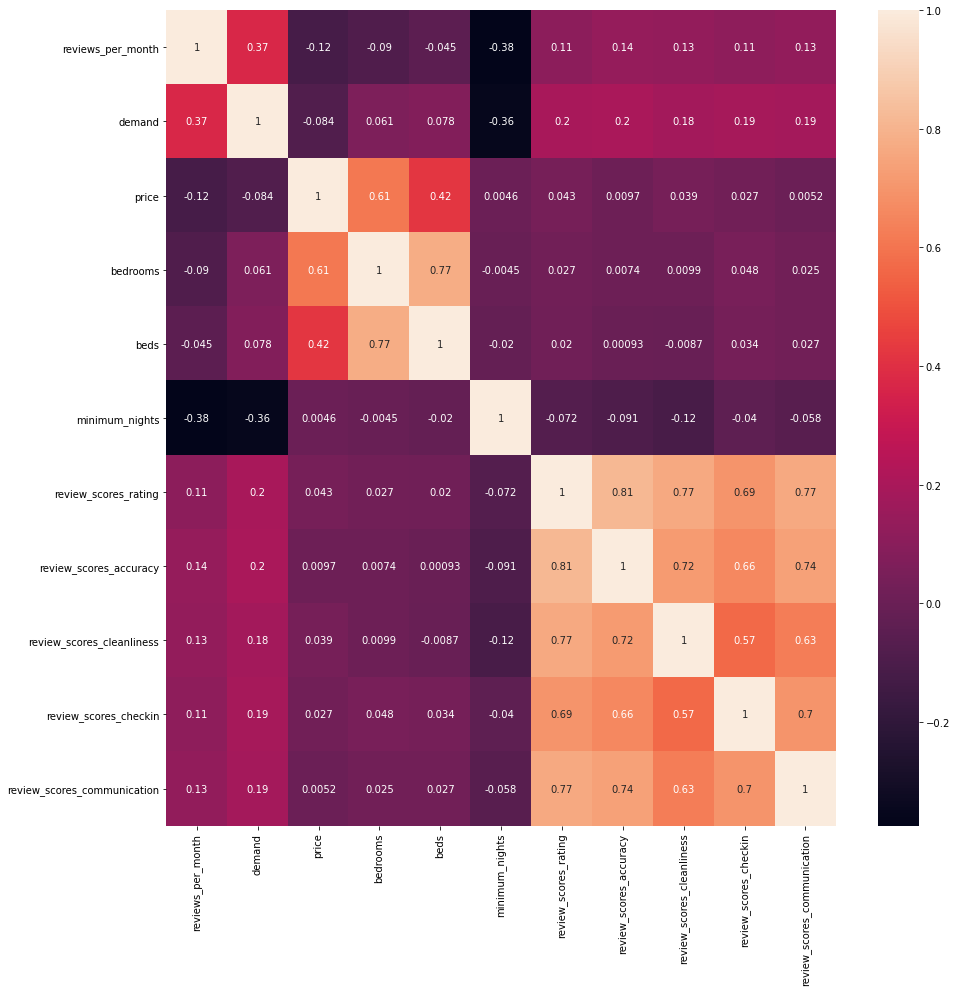

In [51]:
matrix = df.iloc[:,1:15].corr(method = 'pearson')
plt.figure(figsize=(15,15))
sns.heatmap(matrix, annot=True)
#plt.show()
plt.savefig('corr_map.png')

We see that Demand does not have a high correlation with other independent variables that we are using to build the model to predict demand therefore we can move on to building models to use all the variables to predict demand.

## XGBoost Regression

In [53]:
# conda install py-xgboost
import xgboost as xgb
from random import uniform
from random import randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [54]:
df.zipcode_large = [str(i) for i in df.zipcode_large]

In [55]:
df.columns

Index(['id', 'reviews_per_month', 'demand', 'price', 'neighbourhood_cleansed',
       'bedrooms', 'beds', 'room_type', 'minimum_nights', 'listing_url',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'host_since', 'calculated_host_listings_count',
       'accommodates', 'price_per_person', 'log_demand', 'zipcode',
       'housing_price', 'property_0', 'property_1', 'property_2', 'property_3',
       'property_4', 'property_5', 'property_6', 'property_7', 'property_8',
       'property_9', 'amenity_0', 'amenity_1', 'amenity_2', 'amenity_3',
       'amenity_4', 'amenity_5', 'amenity_6', 'amenity_7', 'amenity_8',
       'amenity_9', 'amenity_10', 'amenity_11', 'amenity_12', 'amenity_13',
       'amenity_14', 'amenity_15', 'amenity_16', 'amenity_17', 'amenity_18',
       'amenity_19', 'zipcode_large'],
      dtype='object')

In [56]:
df = df[df['demand'] > 0]

In [57]:
df = pd.merge(df4[['id','longitude', 'latitude']], df, on = ['id'])

In [86]:
model_df = df.drop(["id", "listing_url", "price", "neighbourhood_cleansed", "log_demand", "demand", "zipcode", "zipcode_large", "host_since"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(model_df, df['demand'], test_size=0.1, random_state=42)

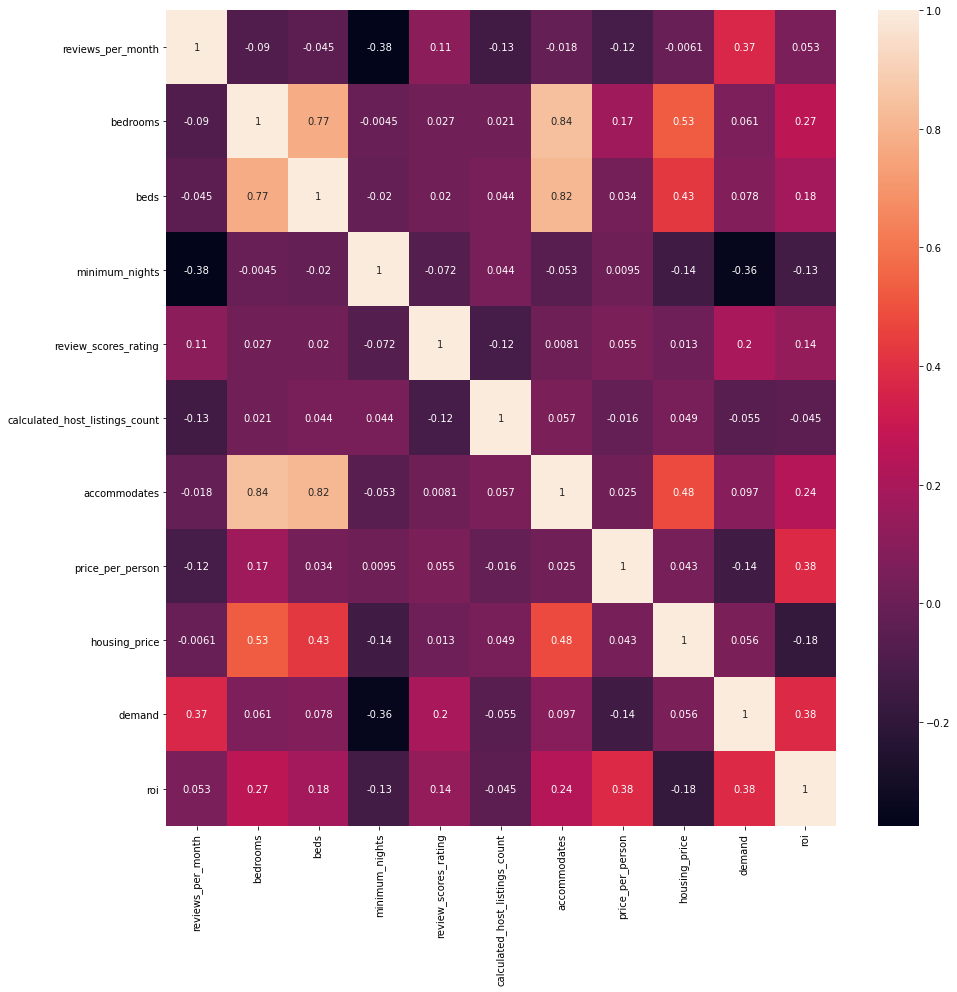

In [88]:
model_df['demand'] = df['demand']
model_df['roi'] = [x*y/housing_price*365 for x,y,housing_price in zip(df['price'], df['demand'],df['housing_price'])]
model_df = model_df.drop(['review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'property_0', 'property_1', 'property_2', 'property_3',
       'property_4', 'property_5', 'property_6', 'property_7', 'property_8',
       'property_9', 'amenity_0', 'amenity_1', 'amenity_2', 'amenity_3',
       'amenity_4', 'amenity_5', 'amenity_6', 'amenity_7', 'amenity_8',
       'amenity_9', 'amenity_10', 'amenity_11', 'amenity_12', 'amenity_13',
       'amenity_14', 'amenity_15', 'amenity_16', 'amenity_17', 'amenity_18',
       'amenity_19',"latitude"], axis = 1)
matrix = model_df.iloc[:,1:].corr(method = 'pearson')
plt.figure(figsize=(15,15))
sns.heatmap(matrix, annot=True)
#plt.show()
plt.savefig('corr_map.png')

In [ ]:
model_df = df.drop(["id", "listing_url", "price", "neighbourhood_cleansed", "log_demand", "demand", "zipcode", "zipcode_large", "host_since"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(model_df, df['demand'], test_size=0.1, random_state=42)

In [87]:
model_df.columns

Index(['longitude', 'latitude', 'reviews_per_month', 'bedrooms', 'beds',
       'room_type', 'minimum_nights', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'accommodates', 'price_per_person',
       'housing_price', 'property_0', 'property_1', 'property_2', 'property_3',
       'property_4', 'property_5', 'property_6', 'property_7', 'property_8',
       'property_9', 'amenity_0', 'amenity_1', 'amenity_2', 'amenity_3',
       'amenity_4', 'amenity_5', 'amenity_6', 'amenity_7', 'amenity_8',
       'amenity_9', 'amenity_10', 'amenity_11', 'amenity_12', 'amenity_13',
       'amenity_14', 'amenity_15', 'amenity_16', 'amenity_17', 'amenity_18',
       'amenity_19'],
      dtype='object')

In [289]:
# model_df.to_csv("cleaned_data.csv")

In [417]:
cat_cols = X_train.columns[X_train.dtypes == 'object']
num_cols = X_train.columns[(X_train.dtypes == 'float64') | (X_train.dtypes == 'int64')]

In [418]:
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[cat_cols])
def OneHotEncoding(df, enc, categories):  
    transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
    return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)
X_train = OneHotEncoding(X_train, enc_ohe, cat_cols)
X_test = OneHotEncoding(X_test, enc_ohe, cat_cols)

In [419]:
X_train

longitude  latitude  reviews_per_month  bedrooms  beds  minimum_nights  \
0    -118.33713  34.20694               1.19       3.0   3.0               2   
1    -118.11881  34.09500               3.95       1.0   1.0               1   
2    -118.25283  34.13877               4.94       2.0   2.0               2   
3    -118.59098  34.10102               2.87       1.0   1.0               2   
4    -117.91628  33.99046               1.86       1.0   2.0               1   
...         ...       ...                ...       ...   ...             ...   
3846 -118.34981  34.09659               0.12       2.0   2.0              30   
3847 -118.40176  33.93071               0.15       2.0   2.0               3   
3848 -118.31919  33.96381               4.08       1.0   1.0               1   
3849 -118.39533  33.84759               0.31       1.0   1.0               7   
3850 -118.35647  33.91190               3.91       2.0   3.0               2   

      review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                     99.0                    10.0                       10.0   
1                     93.0                    10.0                        9.0   
2                     97.0                    10.0                       10.0   
3                    100.0                    10.0                       10.0   
4                     96.0                    10.0                       10.0   
...                    ...                     ...                        ...   
3846                 100.0                    10.0                       10.0   
3847                 100.0                    10.0                       10.0   
3848                  96.0                    10.0                        9.0   
3849                 100.0                    10.0                       10.0   
3850                  97.0                    10.0                       10.0   

      review_scores_checkin  ...  amenity_14  amenity_15  amenity_16  \
0                      10.0  ...    0.044240    0.039159    0.042426   
1                      10.0  ...    0.163265    0.058834    0.212884   
2                      10.0  ...   -0.023893    0.268981    0.018140   
3                      10.0  ...   -0.069880   -0.006819    0.281394   
4                      10.0  ...   -0.221628   -0.039961    0.077988   
...                     ...  ...         ...         ...         ...   
3846                   10.0  ...    0.047425    0.139223    0.039921   
3847                   10.0  ...    0.046561    0.054095   -0.036020   
3848                   10.0  ...   -0.204440    0.234051   -0.001489   
3849                   10.0  ...   -0.074926   -0.074780    0.271602   
3850                   10.0  ...   -0.191084   -0.049859   -0.162009   

      amenity_17  amenity_18  amenity_19  room_type_Entire home/apt  \
0       0.171129   -0.092329   -0.035240                        1.0   
1      -0.082107   -0.049452   -0.020156                        0.0   
2       0.049733    0.141563    0.128534                        1.0   
3      -0.001159    0.025831   -0.145167                        1.0   
4       0.039391   -0.259358   -0.001170                        1.0   
...          ...         ...         ...                        ...   
3846   -0.121511   -0.109907   -0.034854                        1.0   
3847   -0.057836    0.068479    0.035303                        1.0   
3848   -0.023756    0.059722   -0.035497                        1.0   
3849    0.311237   -0.025348    0.116021                        0.0   
3850   -0.118707    0.100157    0.138799                        1.0   

      room_type_Hotel room  room_type_Private room  room_type_Shared room  
0                      0.0                     0.0                    0.0  
1                      0.0                     1.0                    0.0  
2                      0.0                     0.0                    0.0  
3                      0.0                     0.0

In [420]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'learning_rate': np.arange(0.001, 0.1, (0.1-0.001)/5), # default 0.1 
          'max_depth': np.arange(2, 6, 1), # default 3
          'n_estimators': np.arange(100, 250, 50)}
xgb_model = xgb.XGBRegressor(random_state=42)

In [421]:
xgb_search = GridSearchCV(xgb_model, params, cv=5)

In [422]:
%time xgb_search.fit(X_train, y_train)

Wall time: 1min 37s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [423]:
xgb_search.best_params_

{'learning_rate': 0.08020000000000001, 'max_depth': 5, 'n_estimators': 200}

In [424]:
fi_dict = dict()
for x, y in zip(xgb_search.best_estimator_.get_booster().feature_names, xgb_search.best_estimator_.feature_importances_):
    fi_dict[x] = y

In [425]:
fi_list = [[x, y] for x, y in zip(xgb_search.best_estimator_.get_booster().feature_names, xgb_search.best_estimator_.feature_importances_)]

In [426]:
fi_list.sort(key = lambda x: -x[1])

In [427]:
fi_list[:20]

[['room_type_Entire home/apt', 0.1727076],
 ['reviews_per_month', 0.1053177],
 ['minimum_nights', 0.05669014],
 ['review_scores_checkin', 0.052946396],
 ['calculated_host_listings_count', 0.03393199],
 ['property_0', 0.03236938],
 ['room_type_Hotel room', 0.027731454],
 ['review_scores_communication', 0.026884146],
 ['room_type_Private room', 0.023410836],
 ['price_per_person', 0.020612497],
 ['property_9', 0.018182166],
 ['review_scores_value', 0.017899485],
 ['amenity_0', 0.017193614],
 ['review_scores_rating', 0.015988521],
 ['property_3', 0.015389038],
 ['review_scores_location', 0.014133591],
 ['property_6', 0.013428939],
 ['property_5', 0.013348099],
 ['review_scores_accuracy', 0.013158756],
 ['property_8', 0.0129157975]]

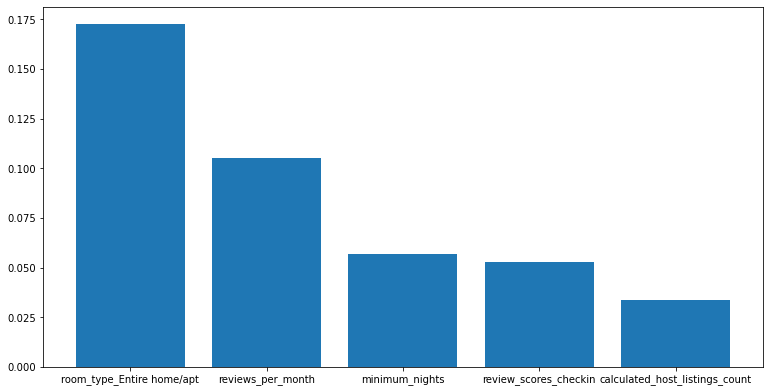

In [428]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar([x[0] for x in fi_list[:5]],[x[1] for x in fi_list[:5]])
plt.show()

## Model Evaluation

<AxesSubplot:>

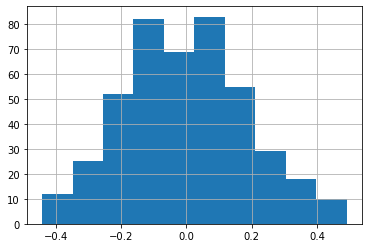

In [63]:
(xgb_search.predict(X_test)-y_test).hist()

<AxesSubplot:>

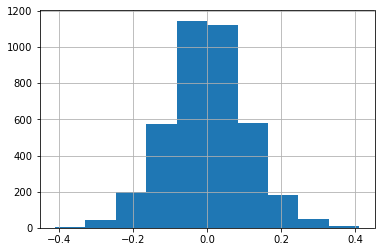

In [64]:
(xgb_search.predict(X_train) - y_train).hist()

In [429]:
import shap
from sklearn.model_selection import cross_validate

In [91]:
model = GradientBoostingRegressor(learning_rate=0.08020000000000001, 
                                  max_depth=5,
                                  n_estimators=200).fit(X_train, y_train)

In [92]:
Y_pred = model.predict(X_test)

In [93]:
print('Error for XGBoost is :', np.mean((y_test-Y_pred)**2))

Error for XGBoost is : 0.0350782537585018


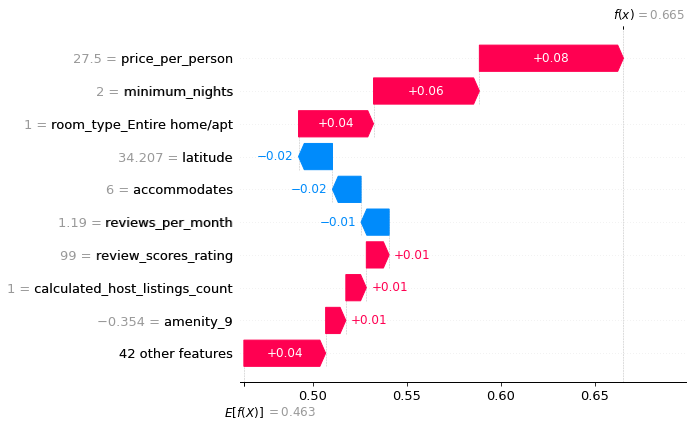

In [430]:
explainer = shap.TreeExplainer(xgb_search.best_estimator_)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=10)

In [286]:
shap.initjs()
shap.plots.force(shap_values[0])

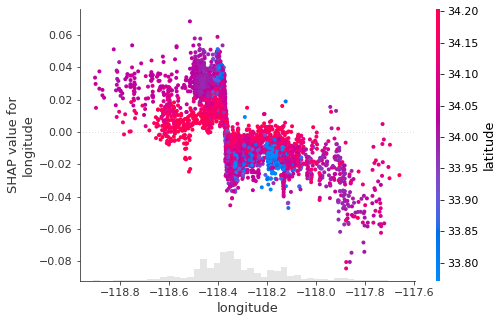

In [72]:
shap.plots.scatter(shap_values[:,"longitude"], color=shap_values)

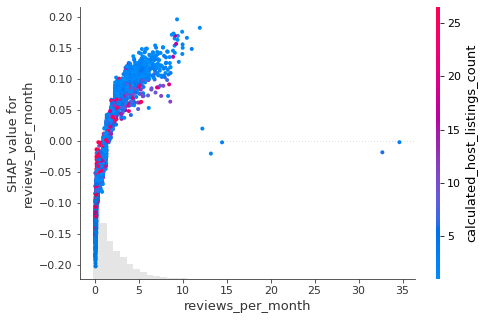

In [434]:
shap.plots.scatter(shap_values[:,"reviews_per_month"], color=shap_values)

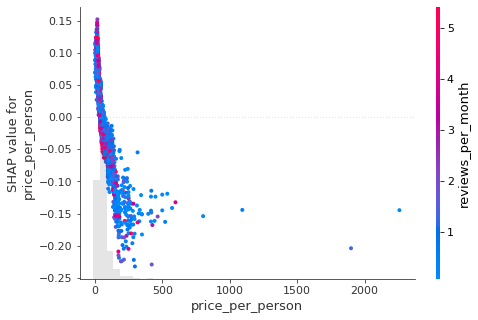

In [431]:
shap.plots.scatter(shap_values[:,"price_per_person"], color=shap_values)

In [195]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
pdp = partial_dependence(
    model, X_train, features=['longitude', 'latitude'], kind="average", grid_resolution=100
)

In [206]:
s = XX.shape[0]*XX.shape[1]
map_pdp = pd.DataFrame({'longitude':[x[0] for x in XX.reshape([s, 1])], 'latitude':[x[0] for x in YY.reshape([s, 1])], 
                        'value':[x[0] for x in Z.T.reshape([s, 1])]})

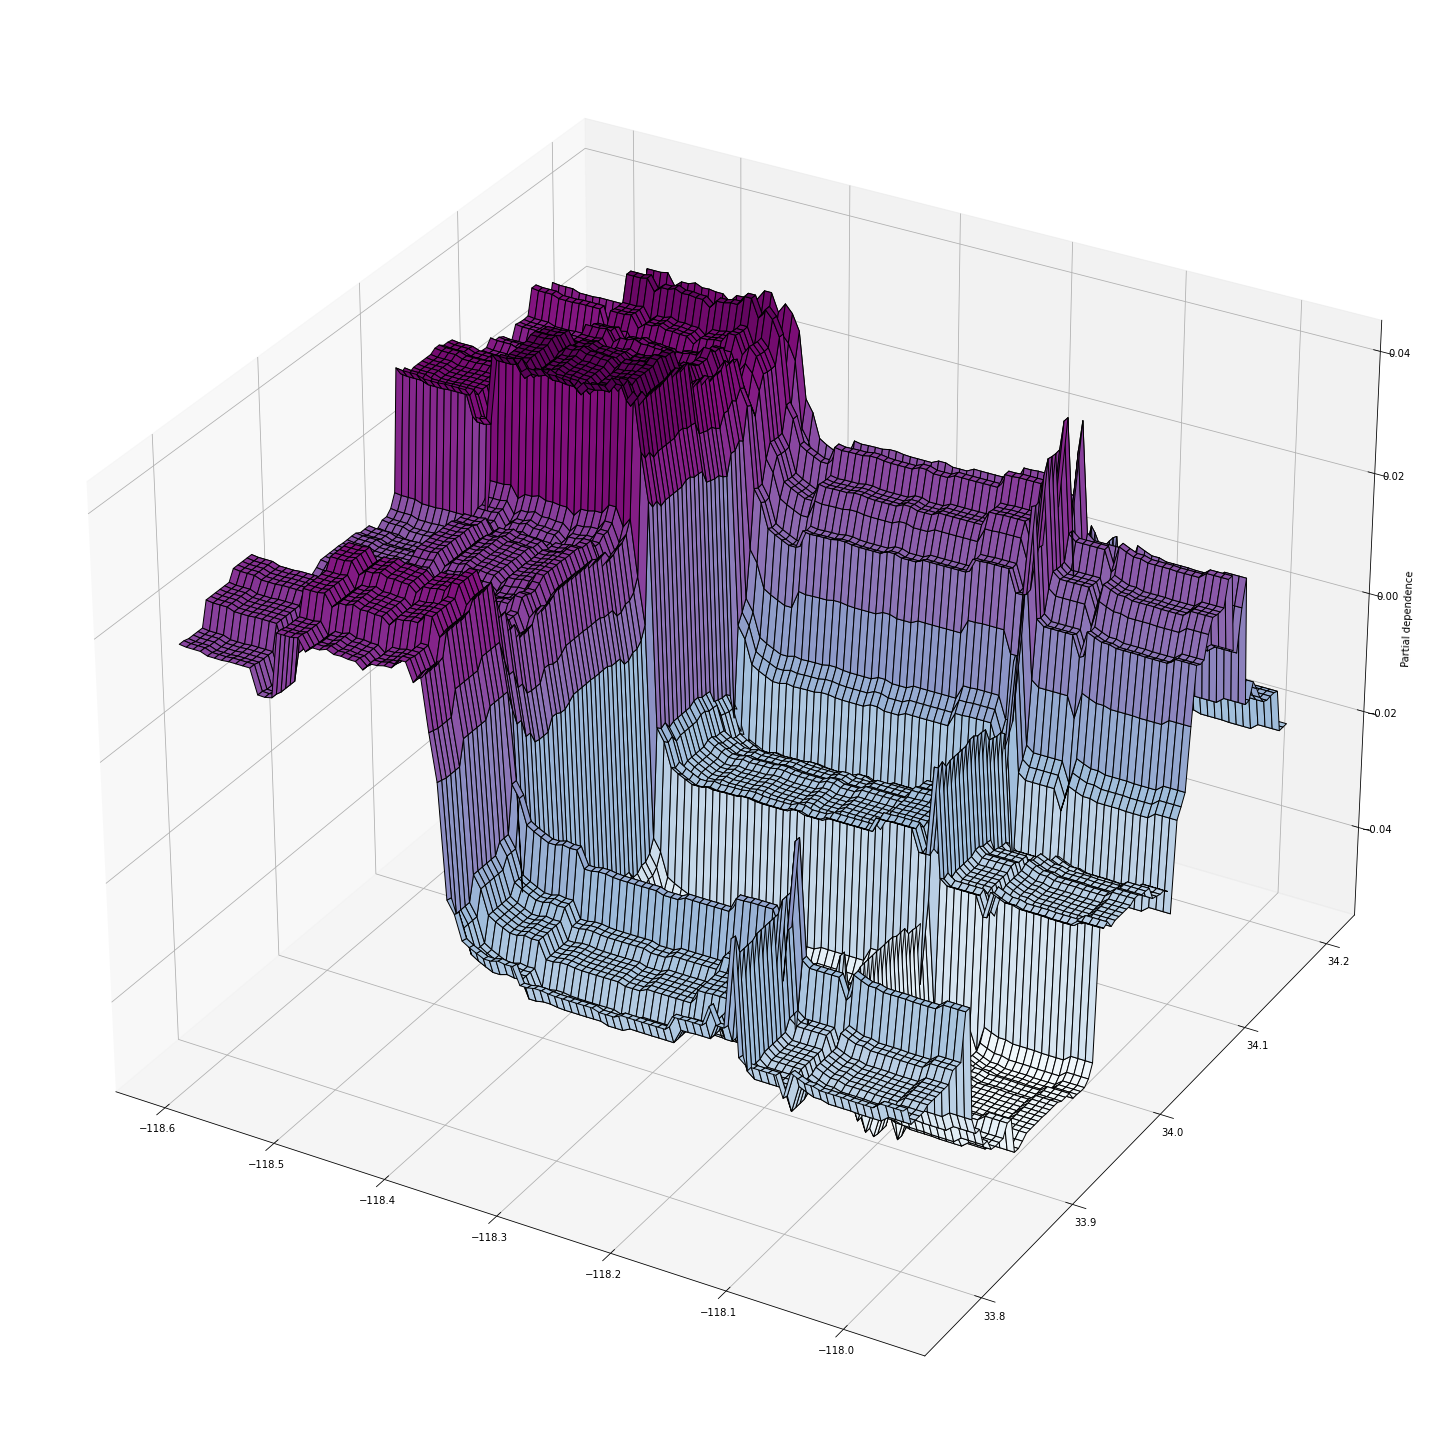

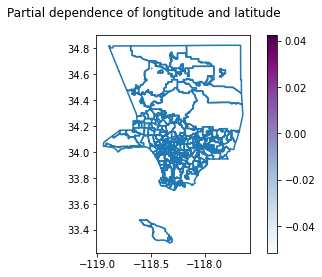

In [155]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_zlabel("Partial dependence")
# pretty init view
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of longtitude and latitude"
)
plt.show()

<Figure size 2160x2880 with 0 Axes>

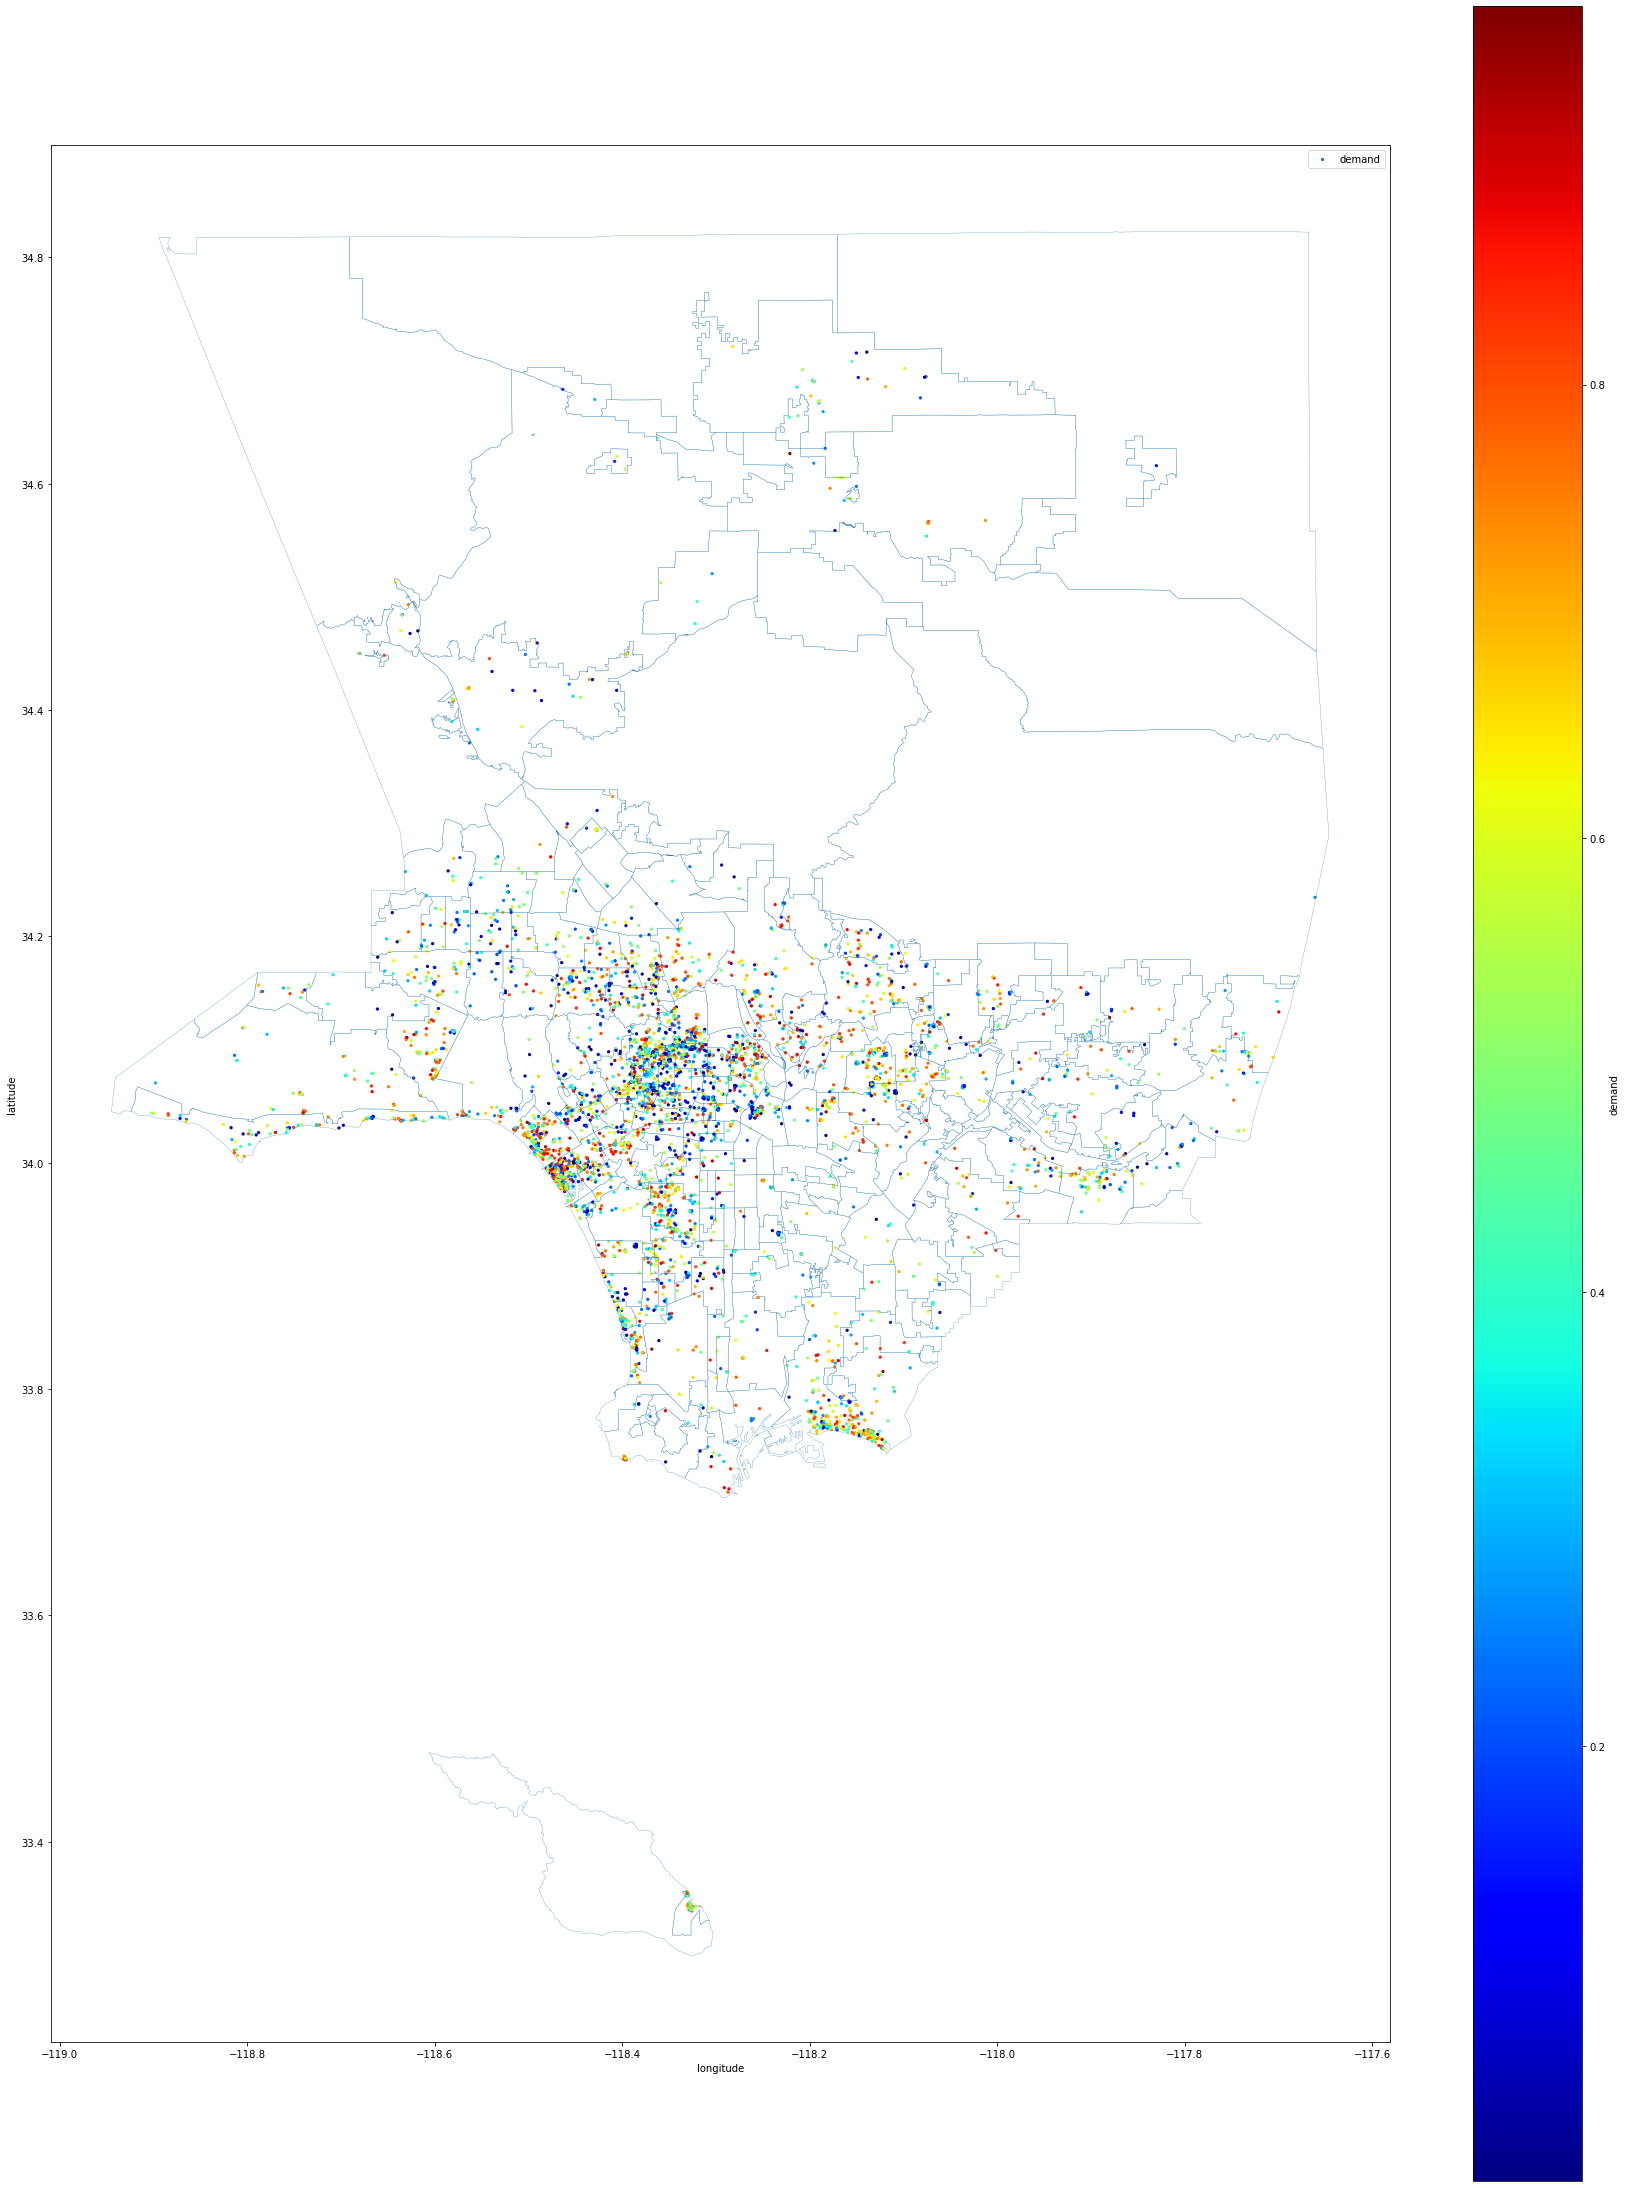

In [210]:
la_map = gpd.read_file('Data/neighbourhoods.geojson')

plt.figure(figsize=(30,40))
ax = la_map.boundary.plot(linewidth = 0.25)
ax.set_facecolor("white")
df.plot(kind='scatter', x='longitude', y='latitude', label='demand', c='demand',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=1, s=  5, figsize=(30,40), ax=ax)

plt.legend()
plt.show()

In [ ]:
shap.plots.scatter(shap_values[:,"price_per_person"], color=shap_values)

In [169]:
reg = LinearRegression().fit(shap_values[:,"price_per_person"].data.reshape([len(shap_values[:,"price_per_person"].data),1]), shap_values[:,"price_per_person"].values)

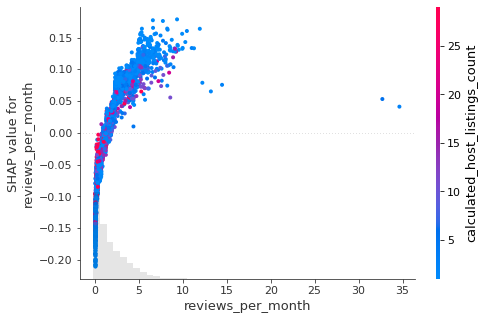

In [66]:
shap.plots.scatter(shap_values[:,"reviews_per_month"], color=shap_values)

#### Mean Squared Error for XGBoost

In [61]:
print('Error for XGBoost is: ', np.mean((xgb_search.best_estimator_.predict(X_test)-y_test)**2))

Error for XGBoost is:  0.03666768540028545


### CV permute feature importance

In [62]:
feature_importance = {}
for columns in X_train.columns:
    old_column = X_train[columns].copy()
    X_train[columns] = np.random.permutation(X_train[columns])
    model = xgb_search.best_estimator_
    cv_results = cross_validate(model, X_train, y_train, cv=5)
    feature_importance[columns] = np.mean(cv_results['test_score'])
    X_train[columns] = old_column
    

In [63]:
feature_importance # The bigger the better

{'reviews_per_month': 0.4097085527123741,
 'bedrooms': 0.4360915998050636,
 'beds': 0.43683234081189176,
 'minimum_nights': 0.3845514000202171,
 'review_scores_rating': 0.42831588705001067,
 'calculated_host_listings_count': 0.41889315507409774,
 'accommodates': 0.4341130644684383,
 'price_per_person': 0.4025492057787633,
 'housing_price': 0.4341429717627988,
 'property_0': 0.437792723202563,
 'property_1': 0.4378443430730969,
 'property_2': 0.4384851953719469,
 'property_3': 0.4378417553200517,
 'property_4': 0.43377528772960466,
 'property_5': 0.43761338565446417,
 'property_6': 0.43603847774358134,
 'property_7': 0.43895620053953327,
 'property_8': 0.4369240218621191,
 'property_9': 0.4381916756014605,
 'amenity_0': 0.43587681570204406,
 'amenity_1': 0.43398658390518163,
 'amenity_2': 0.43307529847242954,
 'amenity_3': 0.43359926896787593,
 'amenity_4': 0.4366246300266671,
 'amenity_5': 0.4364783094382741,
 'amenity_6': 0.4378521274157562,
 'amenity_7': 0.4349605715602719,
 'amenity

### StandardScaler

In [301]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train.iloc[:,:-4])

In [302]:
transformed = pd.DataFrame(scaler.transform(X_train.iloc[:,:-4]), columns=X_train.columns[:-4])
X_train = pd.concat([transformed, X_train.iloc[:,-4:]], axis=1)

In [303]:
transformed = pd.DataFrame(scaler.transform(X_test.iloc[:,:-4]), columns=X_test.columns[:-4])
X_test = pd.concat([transformed, X_test.iloc[:,-4:]], axis=1)

In [304]:
X_train

longitude  latitude  reviews_per_month  bedrooms      beds  \
0     -0.079405  1.069271          -0.324795  1.102038  0.378640   
1      1.136771  0.368283           1.083213 -0.641214 -0.703470   
2      0.390198  0.642378           1.588260  0.230412 -0.162415   
3     -1.493505  0.405981           0.532254 -0.641214 -0.703470   
4      2.264988 -0.286366           0.017004 -0.641214 -0.162415   
...         ...       ...                ...       ...       ...   
3846  -0.150040  0.378239          -0.870653  0.230412 -0.162415   
3847  -0.439434 -0.660531          -0.855349  0.230412 -0.162415   
3848   0.020532 -0.453253           1.149533 -0.641214 -0.703470   
3849  -0.403615 -1.181044          -0.773725 -0.641214 -0.703470   
3850  -0.187141 -0.778323           1.062807  0.230412  0.378640   

      minimum_nights  review_scores_rating  review_scores_accuracy  \
0          -0.679973              0.475216                0.394974   
1          -0.752794             -0.262710                0.394974   
2          -0.679973              0.229241                0.394974   
3          -0.679973              0.598204                0.394974   
4          -0.752794              0.106253                0.394974   
...              ...                   ...                     ...   
3846        1.359020              0.598204                0.394974   
3847       -0.607152              0.598204                0.394974   
3848       -0.752794              0.106253                0.394974   
3849       -0.315867              0.598204                0.394974   
3850       -0.679973              0.229241                0.394974   

      review_scores_cleanliness  review_scores_checkin  ...  amenity_14  \
0                      0.517225               0.285583  ...    0.320737   
1                     -0.580204               0.285583  ...    1.159597   
2                      0.517225               0.285583  ...   -0.159449   
3                      0.517225               0.285583  ...   -0.483557   
4                      0.517225               0.285583  ...   -1.553044   
...                         ...                    ...  ...         ...   
3846                   0.517225               0.285583  ...    0.343179   
3847                   0.517225               0.285583  ...    0.337091   
3848                  -0.580204               0.285583  ...   -1.431906   
3849                   0.517225               0.285583  ...   -0.519122   
3850                   0.517225               0.285583  ...   -1.337781   

      amenity_15  amenity_16  amenity_17  amenity_18  amenity_19  \
0       0.234291    0.282220    1.189457   -0.718772   -0.280683   
1       0.371108    1.443193   -0.496923   -0.399027   -0.168720   
2       1.832444    0.116810    0.381043    1.025419    0.934958   
3      -0.085438    1.909808    0.042138    0.162377   -1.096637   
4      -0.315900    0.524425    0.312172   -1.964349   -0.027793   
...          ...         ...         ...         ...         ...   
3846    0.930121    0.265159   -0.759323   -0.849853   -0.277816   
3847    0.338155   -0.252068   -0.335295    0.480410    0.242934   
3848    1.589547   -0.016886   -0.108342    0.415110   -0.282593   
3849   -0.558027    1.843118    2.122481   -0.219275    0.842078   
3850   -0.384734   -1.110174   -0.740651    0.716647    1.011151   

      room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
0                           1.0                   0.0                     0.0   
1                           0.0                   0.0                     1.0   
2                           1.0                   0.0                     0.0   
3                           1.0                   0.0                     0.0   
4                           1.0                   0.0                     0.0   
...                         ...                   ...                     ...   
3846                        1.0                   0.0          

## Ridge Regression

In [305]:
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report


In [306]:
ridge = Ridge()

In [307]:
params = {'alpha': np.arange(0.1, 10, 0.05)}

In [308]:
ridge_search = GridSearchCV(ridge, params, cv=5)

In [309]:
ridge_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
       1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 ,
       1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15, 2.2 , 2.25,
       2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75, 2.8 ,
       2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25, 3....
       5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 , 5.95, 6.  , 6.05, 6.1 ,
       6.15, 6.2 , 6.25, 6.3 , 6.35, 6.4 , 6.45, 6.5 , 6.55, 6.6 , 6.65,
       6.7 , 6.75, 6.8 , 6.85, 6.9 , 6.95, 7.  , 7.05, 7.1 , 7.15, 7.2 ,
       7.25, 7.3 , 7.35, 7.4 , 7.45, 7.5 , 7.55, 7.6 , 7.65, 7.7 , 7.75,
       7.8 , 7.85, 7.9 , 7.95, 8.  , 8.05, 8.1 , 8.15, 8.2 , 8.25, 8.3 ,
       8.35, 8.4 , 8.45, 8.5 , 8.55, 8.6 , 8.65, 8.7 , 8.75, 8.8 , 8.85,
       8.9 , 8.95, 9.  , 9.05, 9.1 , 9.15, 9.2 , 9.25, 9.3

In [232]:
ridge_search.best_estimator_

Ridge(alpha=8.700000000000003)

In [310]:
ft = [[x,y] for x, y in zip(list(X_train.columns),ridge_search.best_estimator_.coef_)]

In [311]:
ft.sort(key = lambda x: -np.abs(x[1]))

In [312]:
ft

[['housing_price', -0.2069335199867381],
 ['price_per_person', 0.13729661475290264],
 ['bedrooms', 0.12130540474858381],
 ['room_type_Entire home/apt', 0.11185541917326025],
 ['minimum_nights', -0.08179802631206924],
 ['room_type_Private room', -0.06903373447311267],
 ['longitude', -0.05899259360767804],
 ['room_type_Shared room', -0.051121935859040964],
 ['accommodates', 0.04469208558651746],
 ['amenity_0', 0.03907888625326317],
 ['amenity_4', 0.034450448671282975],
 ['amenity_5', -0.02991968592454918],
 ['review_scores_rating', 0.024889961397544867],
 ['amenity_6', -0.023257019406893585],
 ['review_scores_communication', -0.01838417153839362],
 ['review_scores_accuracy', 0.016944636382813263],
 ['calculated_host_listings_count', -0.016224369077816308],
 ['beds', -0.014936238425640224],
 ['amenity_9', -0.014595961900861106],
 ['amenity_1', 0.014447034522133459],
 ['amenity_14', -0.014141150794983752],
 ['property_0', -0.013465252347243068],
 ['amenity_11', 0.012812771314587044],
 ['am

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  1.,  1.,  1.,  3.,  2.,  1.,  2.,  2.,  0.,  3.,
         2.,  3.,  3.,  4.,  9., 22., 26., 38., 49., 61., 64., 42., 34.,
        25., 14.,  5.,  2.,  2.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,
         1.]),
 array([-2.43519209, -2.36577176, -2.29635144, -2.22693111, -2.15751079,
        -2.08809046, -2.01867014, -1.94924981, -1.87982949, -1.81040916,
        -1.74098884, -1.67156851, -1.60214819, -1.53272786, -1.46330754,
        -1.39388721, -1.32446689, -1.25504656, -1.18562624, -1.11620591,
        -1.04678559, -0.97736526, -0.90794494, -0.83852461, -0.76910429,
        -0.69968396, -0.63026364, -0.56084331, -0.49142299, -0.42200266,
        -0.35258234, -0.28316201, -0.21374169, -0.14432136, -0.07490104,
        -0.00548071,  0.06393961,  0.13335994,  0.20278026,  0.27220059,
         0.34162091,  0.41104124,  0.48046156,  0.54988189,  0.61930221,
         0.68872254,  0.75814286,  0

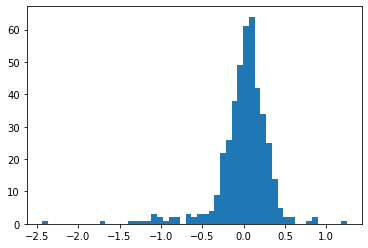

In [313]:
plt.hist(ridge_search.best_estimator_.predict(X_test)- y_test, "auto")

In [314]:
lm = LinearRegression().fit(X_train, y_train)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  1.,  1.,  3.,  2.,  1.,  2.,  2.,  0.,  3.,
         2.,  3.,  3.,  5.,  8., 22., 28., 38., 49., 61., 65., 40., 36.,
        22., 14.,  6.,  1.,  2.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,
         1.]),
 array([-2.43364973e+00, -2.36418171e+00, -2.29471369e+00, -2.22524568e+00,
        -2.15577766e+00, -2.08630964e+00, -2.01684163e+00, -1.94737361e+00,
        -1.87790559e+00, -1.80843758e+00, -1.73896956e+00, -1.66950154e+00,
        -1.60003353e+00, -1.53056551e+00, -1.46109749e+00, -1.39162948e+00,
        -1.32216146e+00, -1.25269344e+00, -1.18322543e+00, -1.11375741e+00,
        -1.04428939e+00, -9.74821378e-01, -9.05353362e-01, -8.35885345e-01,
        -7.66417328e-01, -6.96949312e-01, -6.27481295e-01, -5.58013278e-01,
        -4.88545262e-01, -4.19077245e-01, -3.49609229e-01, -2.80141212e-01,
        -2.10673195e-01, -1.41205179e-01, -7.17371621e-02, -2.26914545e-03,
         

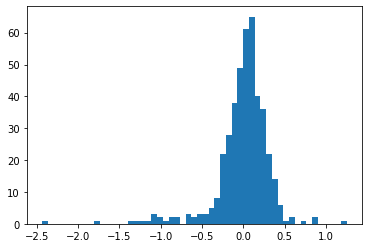

In [318]:
plt.hist(lm.predict(X_test) - y_test, "auto")

#### Mean Squared Error for Ridge Regression

In [75]:
print('Error for Ridge Regressor is: ', np.mean((ridge_search.best_estimator_.predict(X_test)-y_test)**2))

Error for Ridge Regressor is:  0.04357804588075323


In [76]:
print('Error for just guessing the mean is: ', np.var(y_test))

Error for just guessing the mean is:  0.06736333362692852


## Predict Revenue

In [164]:
df.columns

Index(['id', 'reviews_per_month', 'demand', 'price', 'neighbourhood_cleansed',
       'bedrooms', 'beds', 'room_type', 'minimum_nights', 'listing_url',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'host_since', 'calculated_host_listings_count',
       'accommodates', 'price_per_person', 'log_demand', 'zipcode',
       'housing_price', 'property_0', 'property_1', 'property_2', 'property_3',
       'property_4', 'property_5', 'property_6', 'property_7', 'property_8',
       'property_9', 'amenity_0', 'amenity_1', 'amenity_2', 'amenity_3',
       'amenity_4', 'amenity_5', 'amenity_6', 'amenity_7', 'amenity_8',
       'amenity_9', 'amenity_10', 'amenity_11', 'amenity_12', 'amenity_13',
       'amenity_14', 'amenity_15', 'amenity_16', 'amenity_17', 'amenity_18',
       'amenity_19', 'zipcode_large'],
      dtype='object')

In [484]:
model_df = df.drop(["id", "listing_url", "price", "neighbourhood_cleansed", "log_demand", "demand", "zipcode","zipcode_large", "host_since"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(model_df, [x*y/housing_price*365 for x,y,housing_price in zip(df['price'], df['demand'],df['housing_price'])], test_size=0.1, random_state=42)

# model_df.to_csv("cleaned_data.csv")

cat_cols = X_train.columns[X_train.dtypes == 'object']
num_cols = X_train.columns[(X_train.dtypes == 'float64') | (X_train.dtypes == 'int64')]

enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[cat_cols])
def OneHotEncoding(df, enc, categories):  
    transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
    return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)
X_train = OneHotEncoding(X_train, enc_ohe, cat_cols)
X_test = OneHotEncoding(X_test, enc_ohe, cat_cols)

In [326]:
X_train.columns

Index(['longitude', 'latitude', 'reviews_per_month', 'bedrooms', 'beds',
       'minimum_nights', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count', 'accommodates',
       'price_per_person', 'housing_price', 'property_0', 'property_1',
       'property_2', 'property_3', 'property_4', 'property_5', 'property_6',
       'property_7', 'property_8', 'property_9', 'amenity_0', 'amenity_1',
       'amenity_2', 'amenity_3', 'amenity_4', 'amenity_5', 'amenity_6',
       'amenity_7', 'amenity_8', 'amenity_9', 'amenity_10', 'amenity_11',
       'amenity_12', 'amenity_13', 'amenity_14', 'amenity_15', 'amenity_16',
       'amenity_17', 'amenity_18', 'amenity_19', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')

In [300]:
model = GradientBoostingRegressor(learning_rate=0.08020000000000001, 
                                  max_depth=5,
                                  n_estimators=200).fit(X_train, y_train)

In [485]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'learning_rate': np.arange(0.001, 0.1, (0.1-0.001)/5), # default 0.1 
          'max_depth': np.arange(2, 6, 1), # default 3
          'n_estimators': np.arange(100, 250, 50)}
xgb_model = xgb.XGBRegressor(random_state=42)

xgb_search = GridSearchCV(xgb_model, params, cv=5)

%time xgb_search.fit(X_train, y_train)

Wall time: 1min 36s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  2.,  2.,  4.,  2.,  1.,  2.,  3.,  2.,  2.,  4.,  3.,
         5., 18., 17., 24., 49., 65., 57., 48., 32., 28., 13.,  5.,  7.,
         2.,  3.,  6.,  3.,  2.,  1.,  1.,  0.,  2.,  0.,  0.,  1.,  1.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-2.11093023e+00, -2.07456838e+00, -2.03820652e+00, -2.00184467e+00,
        -1.96548281e+00, -1.92912096e+00, -1.89275910e+00, -1.85639724e+00,
        -1.82003539e+00, -1.78367353e+00, -1.74731168e+00, -1.71094982e+00,
        -1.67458797e+00, -1.63822611e+00, -1.60186426e+00, -1.56550240e+00,
        -1.52914054e+00, -1.49277869e+00, -1.45641683e+00, -1.42005498e+00,
        -1.38369312e+00, -1.34733127e+00, -1

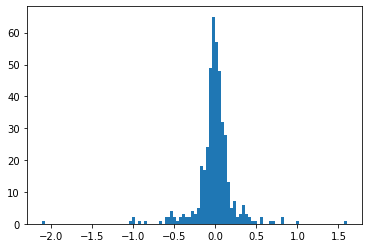

In [181]:
plt.hist(model.predict(X_test) - y_test, bins='auto')

In [182]:
X_test['error'] = (model.predict(X_test) - y_test)**2
X_train['error'] = (model.predict(X_train) - y_train)**2

In [183]:
X_test["pct_error"] = X_test["error"].rank(pct = True)
X_train["pct_error"] = X_train["error"].rank(pct = True)
X_train['error'][X_train['error']>0.05] = 0.05

<Figure size 1440x1440 with 0 Axes>

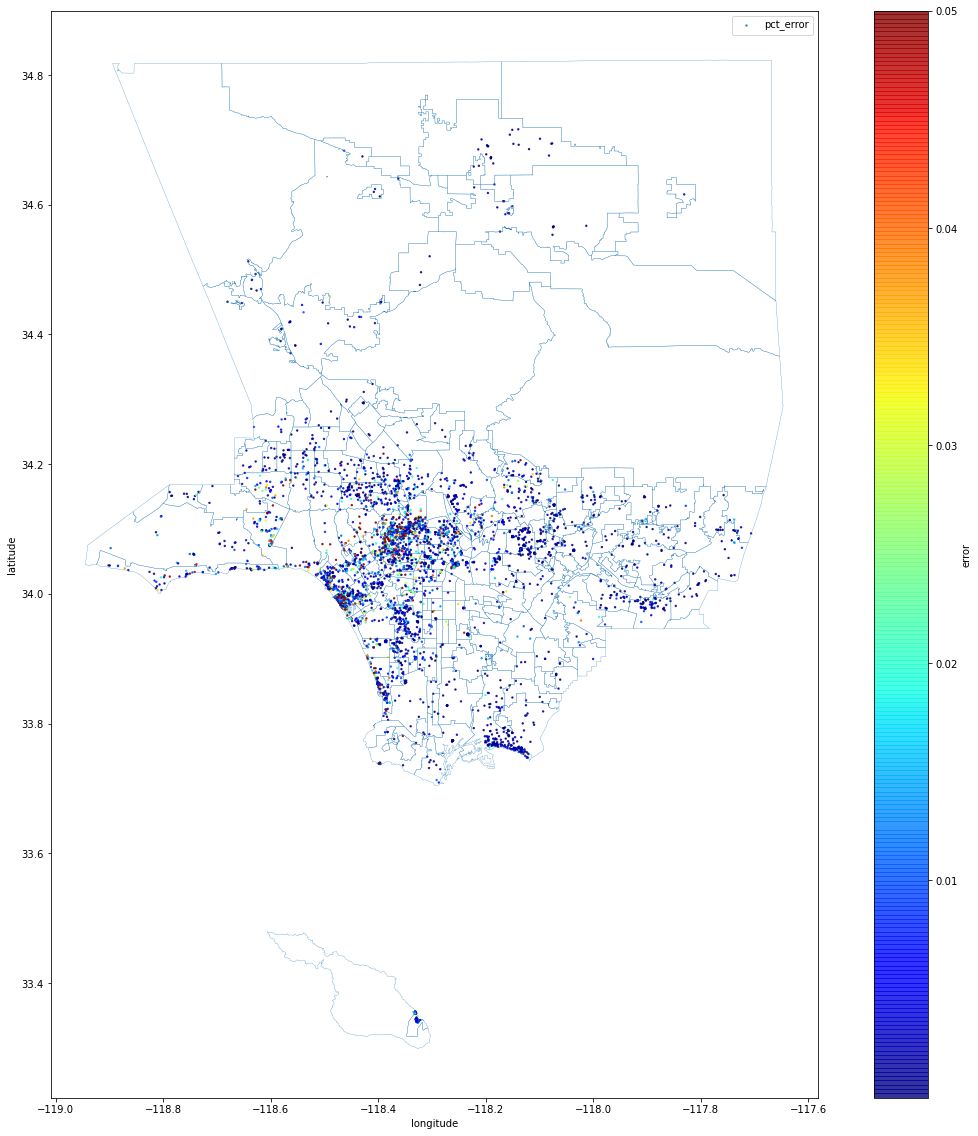

In [184]:
la_map = gpd.read_file('Data/neighbourhoods.geojson')

plt.figure(figsize=(20,20))
ax = la_map.boundary.plot(linewidth = 0.25)
ax.set_facecolor("white")
X_train.plot(kind='scatter', x='longitude', y='latitude', label='pct_error', c='error',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=.8, s=  2, figsize=(20,20), ax=ax)

plt.legend()
#plt.show()
plt.savefig('error_map.png')

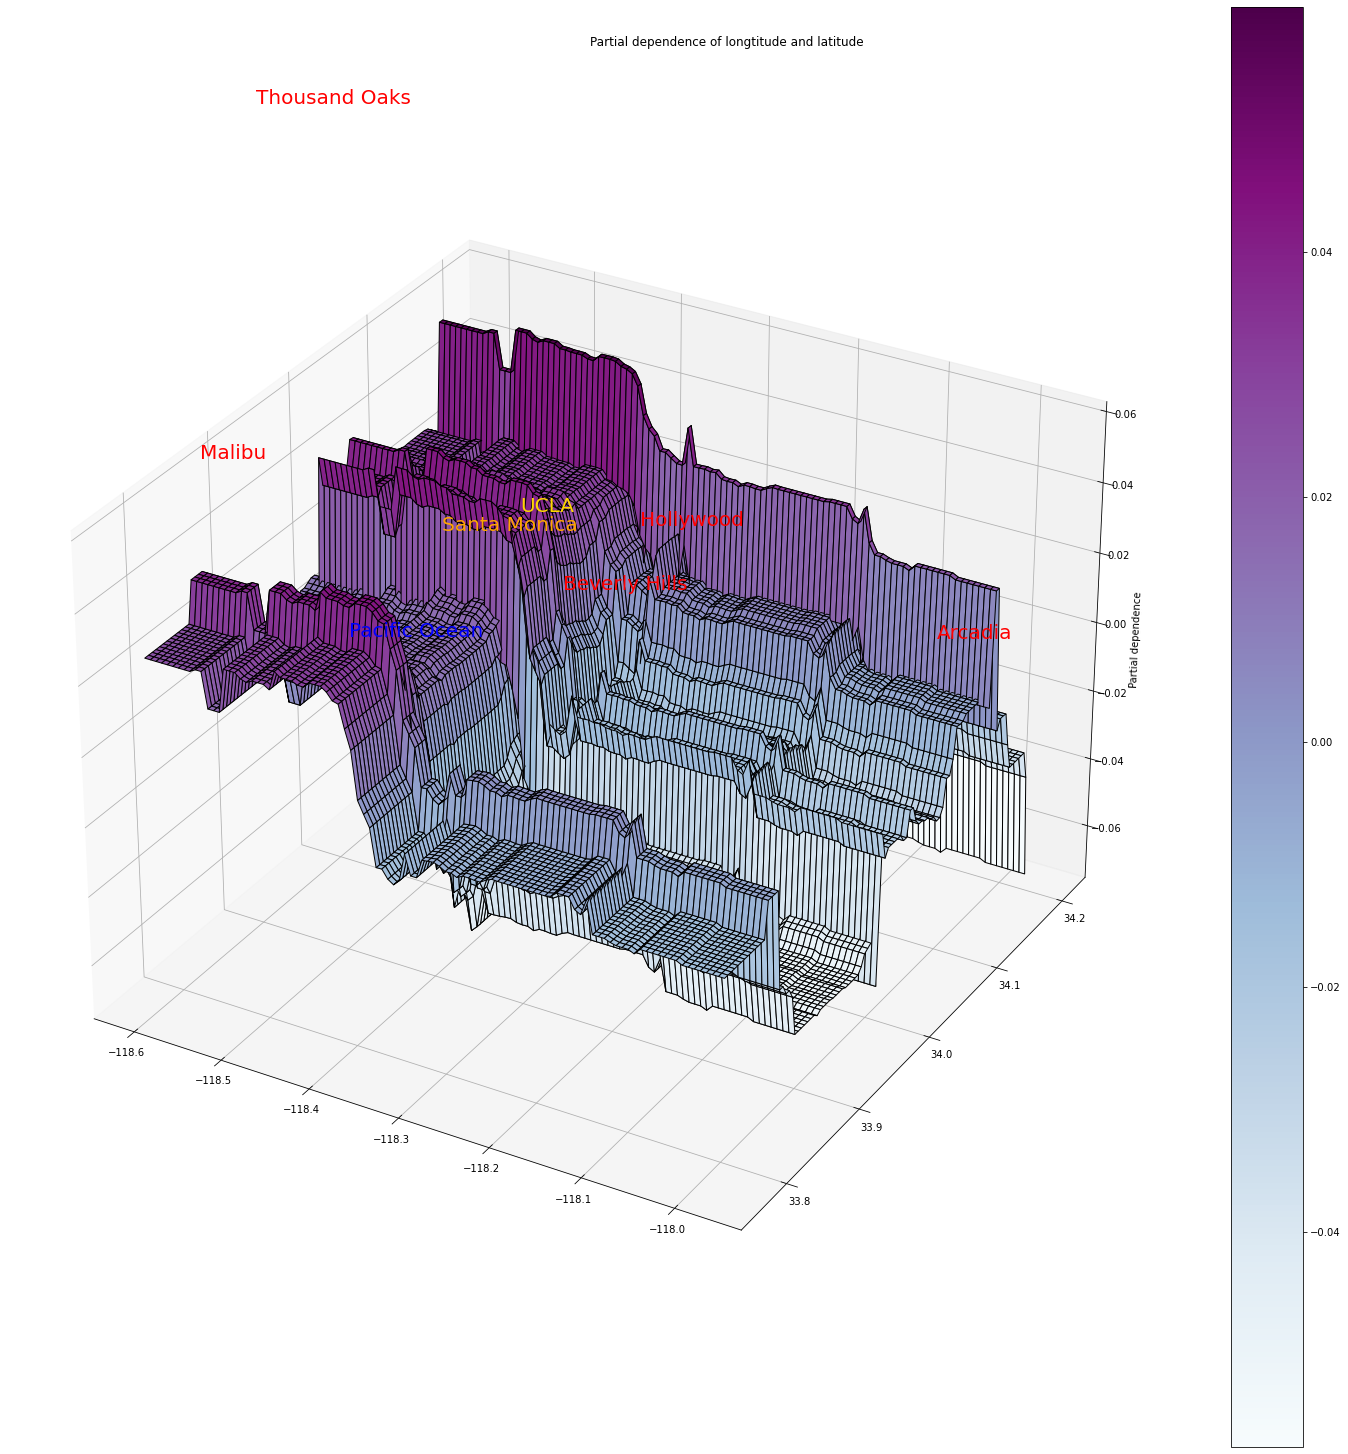

In [247]:
from mpl_toolkits.mplot3d import Axes3D
pdp = partial_dependence(
    model, X_train, features=['longitude', 'latitude'], kind="average", grid_resolution=100
)
fig = plt.figure(figsize=(20,20))
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
ax.text(-118.3287, 34.0928,0.025, "Hollywood", color='red', fontsize = 20, alpha=1)
ax.text(-118.4452, 34.0689, 0.025, "UCLA", color='gold', fontsize = 20, alpha=1)
ax.text( -118.4912, 34.0195, 0.025, "Santa Monica", color='orange', fontsize = 20, alpha=1)
ax.text(-118.7798, 34.0259, 0.025, "Malibu", color='red', fontsize = 20, alpha=1)
ax.text(-118.0353,34.1397, 0.005, "Arcadia", color='red', fontsize = 20, alpha=1)
ax.text(-118.4004, 34.0736,0.005, "Beverly Hills", color='red', fontsize = 20, alpha=1)
ax.text(-118.8376, 34.1706, 0.10, "Thousand Oaks", color='red', fontsize = 20, alpha=1)
ax.text(-118.552225,  33.965270,0.00, "Pacific Ocean", color='blue', fontsize = 20, alpha=1)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_zlabel("Partial dependence")
# pretty init view
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of longtitude and latitude"
)
#plt.show()
plt.savefig('pdp.png')

In [372]:
X_train.columns

Index(['longitude', 'latitude', 'reviews_per_month', 'bedrooms', 'beds',
       'minimum_nights', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count', 'accommodates',
       'price_per_person', 'housing_price', 'property_0', 'property_1',
       'property_2', 'property_3', 'property_4', 'property_5', 'property_6',
       'property_7', 'property_8', 'property_9', 'amenity_0', 'amenity_1',
       'amenity_2', 'amenity_3', 'amenity_4', 'amenity_5', 'amenity_6',
       'amenity_7', 'amenity_8', 'amenity_9', 'amenity_10', 'amenity_11',
       'amenity_12', 'amenity_13', 'amenity_14', 'amenity_15', 'amenity_16',
       'amenity_17', 'amenity_18', 'amenity_19', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')

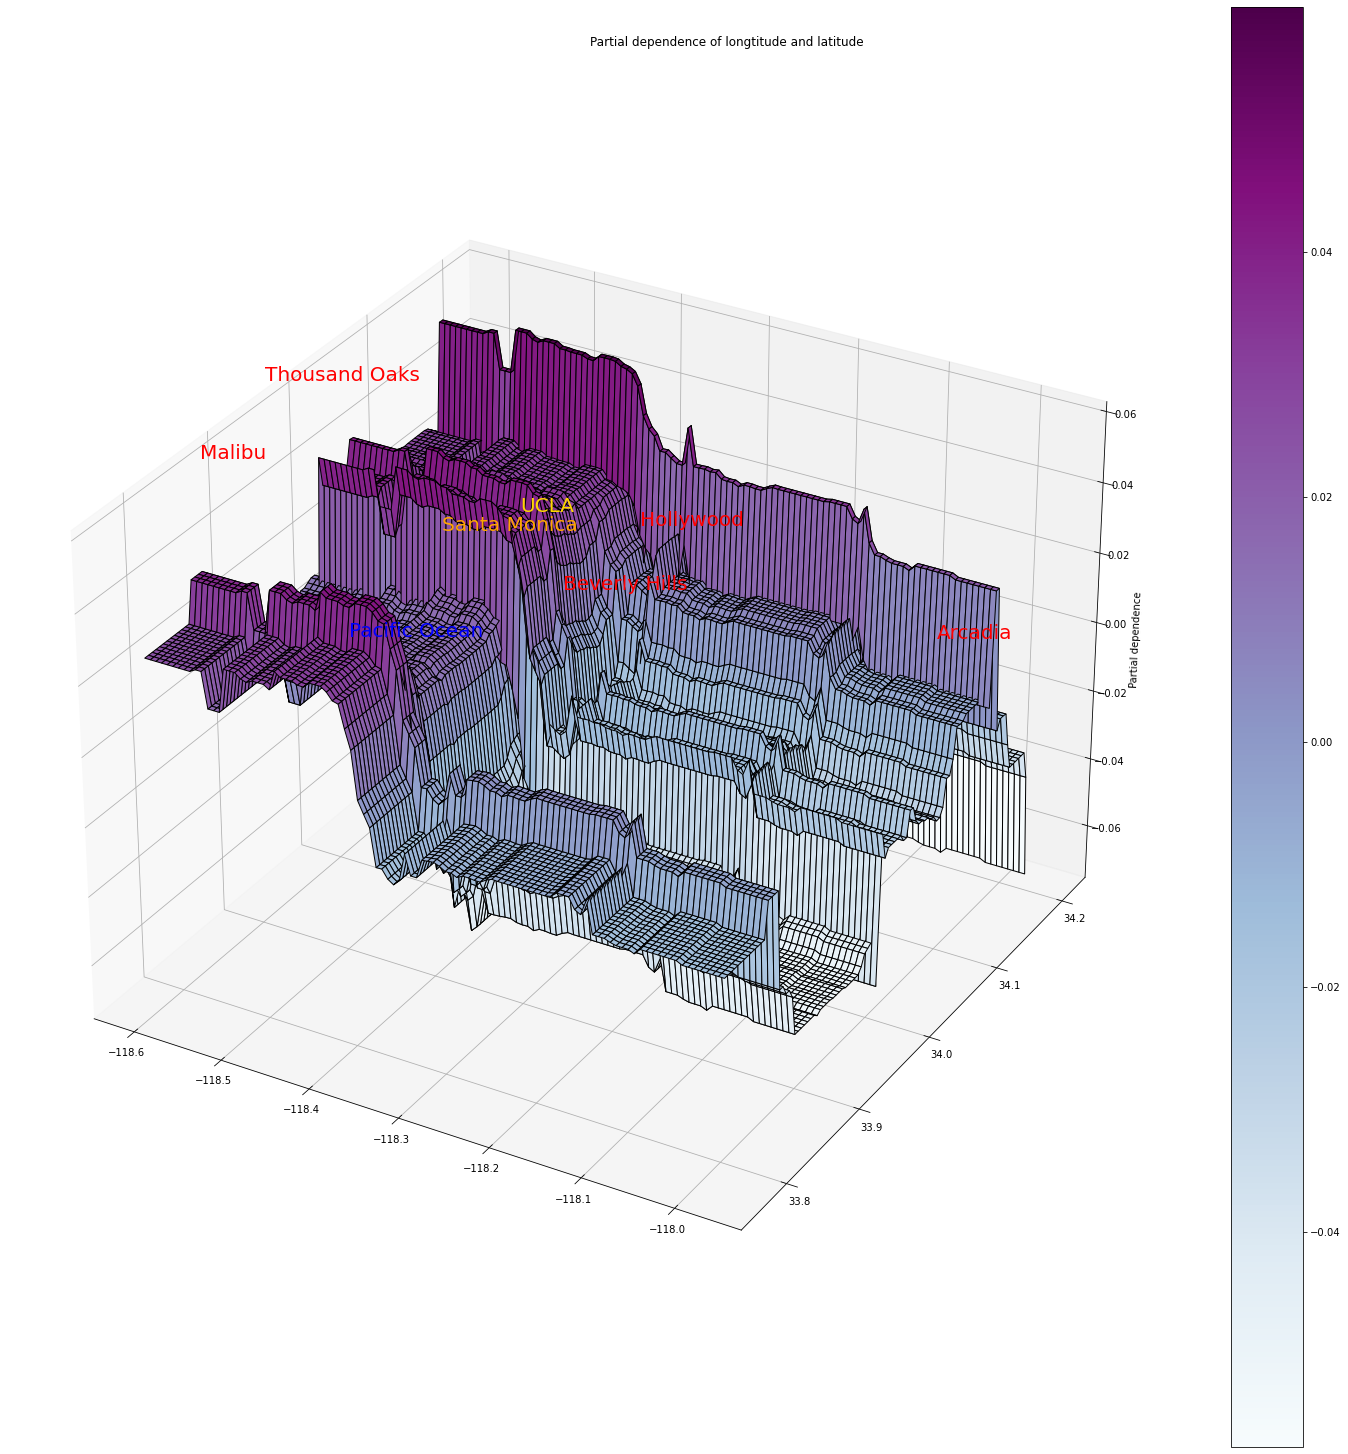

In [248]:
from mpl_toolkits.mplot3d import Axes3D
pdp = partial_dependence(
    model, X_train, features=['longitude', 'latitude'], kind="average", grid_resolution=100
)
fig = plt.figure(figsize=(20,20))
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
ax.text(-118.3287, 34.0928,0.025, "Hollywood", color='red', fontsize = 20, alpha=1)
ax.text(-118.4452, 34.0689, 0.025, "UCLA", color='gold', fontsize = 20, alpha=1)
ax.text( -118.4912, 34.0195, 0.025, "Santa Monica", color='orange', fontsize = 20, alpha=1)
ax.text(-118.7798, 34.0259, 0.025, "Malibu", color='red', fontsize = 20, alpha=1)
ax.text(-118.0353,34.1397, 0.005, "Arcadia", color='red', fontsize = 20, alpha=1)
ax.text(-118.4004, 34.0736,0.005, "Beverly Hills", color='red', fontsize = 20, alpha=1)
ax.text(-118.8376, 34.1706, 0.02, "Thousand Oaks", color='red', fontsize = 20, alpha=1)
ax.text(-118.552225,  33.965270,0.00, "Pacific Ocean", color='blue', fontsize = 20, alpha=1)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_zlabel("Partial dependence")
# pretty init view
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of longtitude and latitude"
)
#plt.show()
plt.savefig('pdp.png')

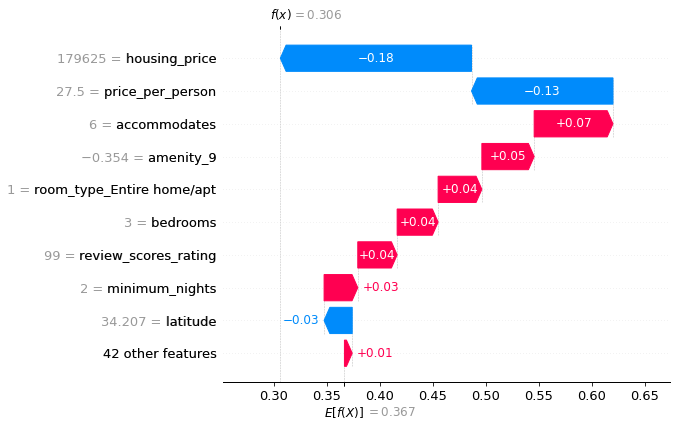

In [329]:
explainer = shap.TreeExplainer(xgb_search.best_estimator_)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [189]:
shap.initjs()
shap.plots.force(shap_values[0])

In [235]:
X_train['housing_price'].describe()

count    3.914000e+03
mean     1.378938e+05
std      1.013913e+05
min      2.129900e+04
25%      6.940500e+04
50%      1.083350e+05
75%      1.826290e+05
max      1.136271e+06
Name: housing_price, dtype: float64

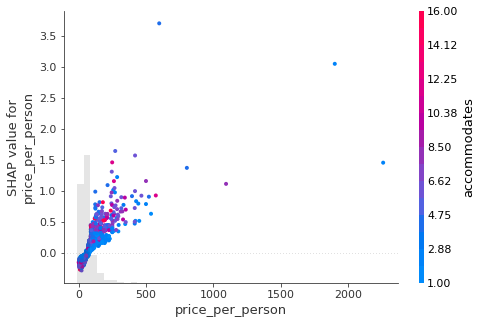

In [374]:
shap.plots.scatter(shap_values[:,"price_per_person"], color=shap_values)

In [337]:
df_location = pd.merge(df4[['id','longitude', 'latitude']], df,on = ['id'])

In [340]:
df['roi'] =  [x*y/housing_price*365 for x,y,housing_price in zip(df['price'], df['demand'],df['housing_price'])]

<Figure size 2160x2880 with 0 Axes>

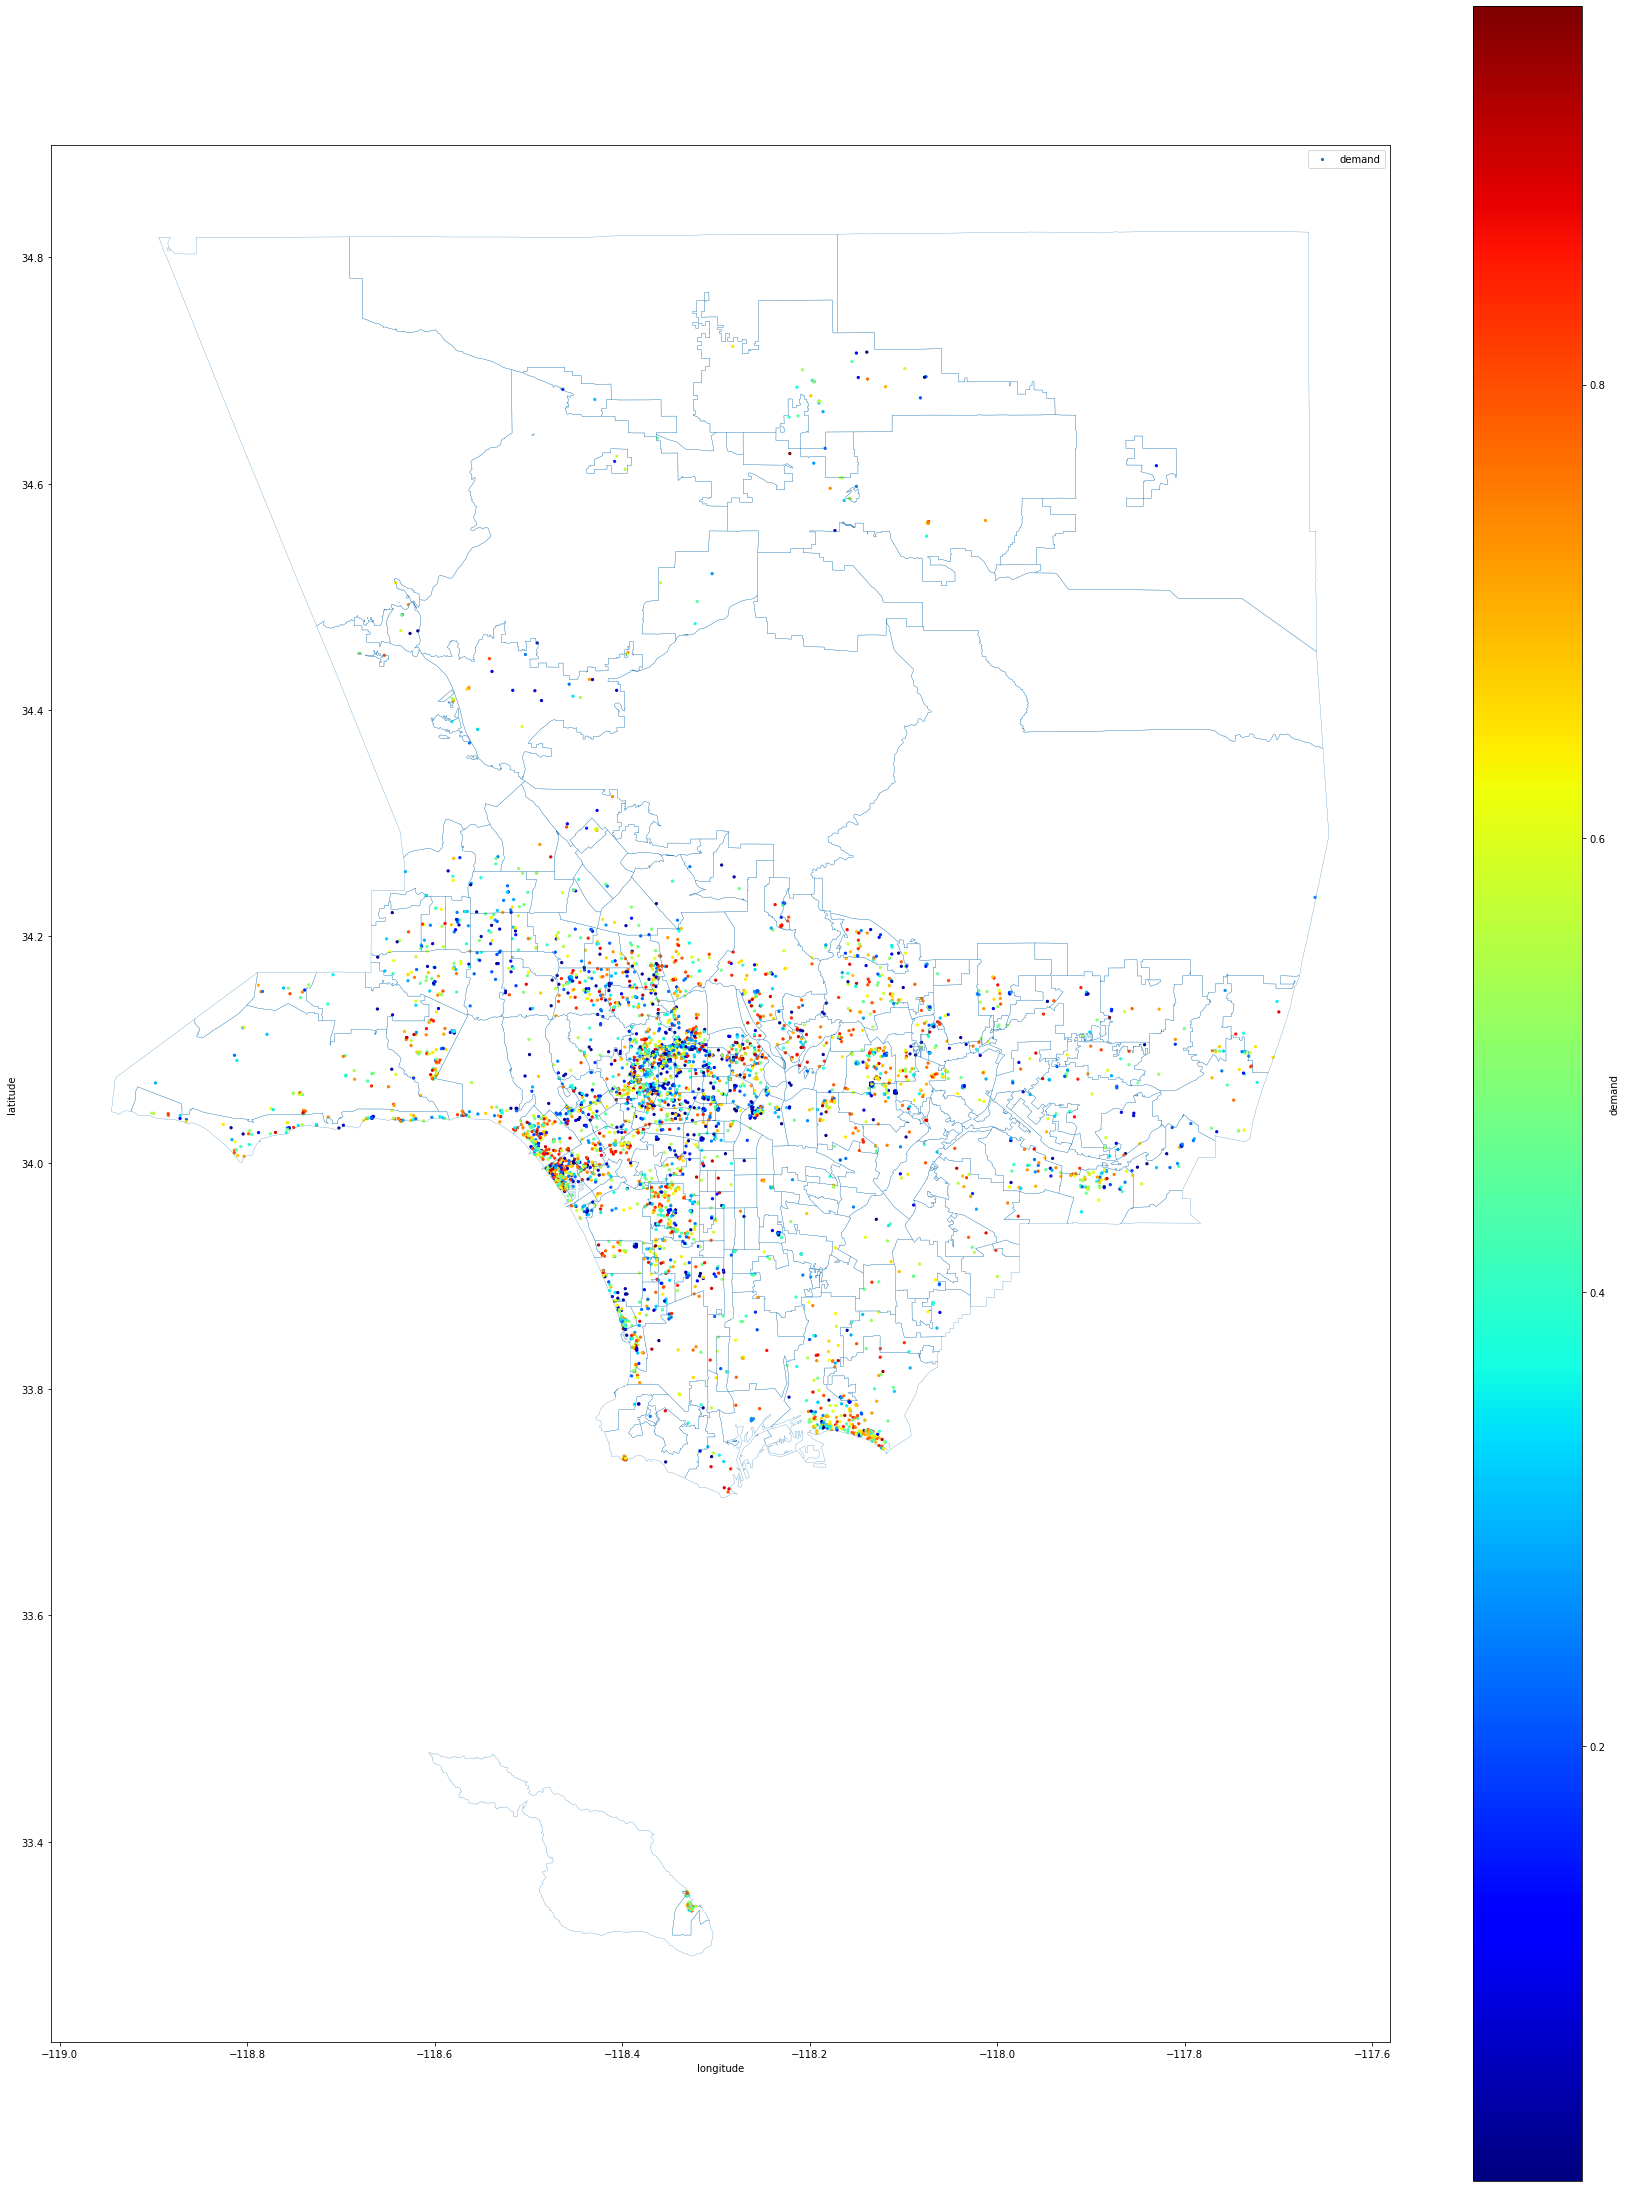

In [342]:
la_map = gpd.read_file('Data/neighbourhoods.geojson')

plt.figure(figsize=(30,40))
ax = la_map.boundary.plot(linewidth = 0.25)
ax.set_facecolor("white")
df.plot(kind='scatter', x='longitude', y='latitude', label='demand', c='demand',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=1, s=  5, figsize=(30,40), ax=ax)

plt.legend()
plt.show()

<Figure size 2160x2880 with 0 Axes>

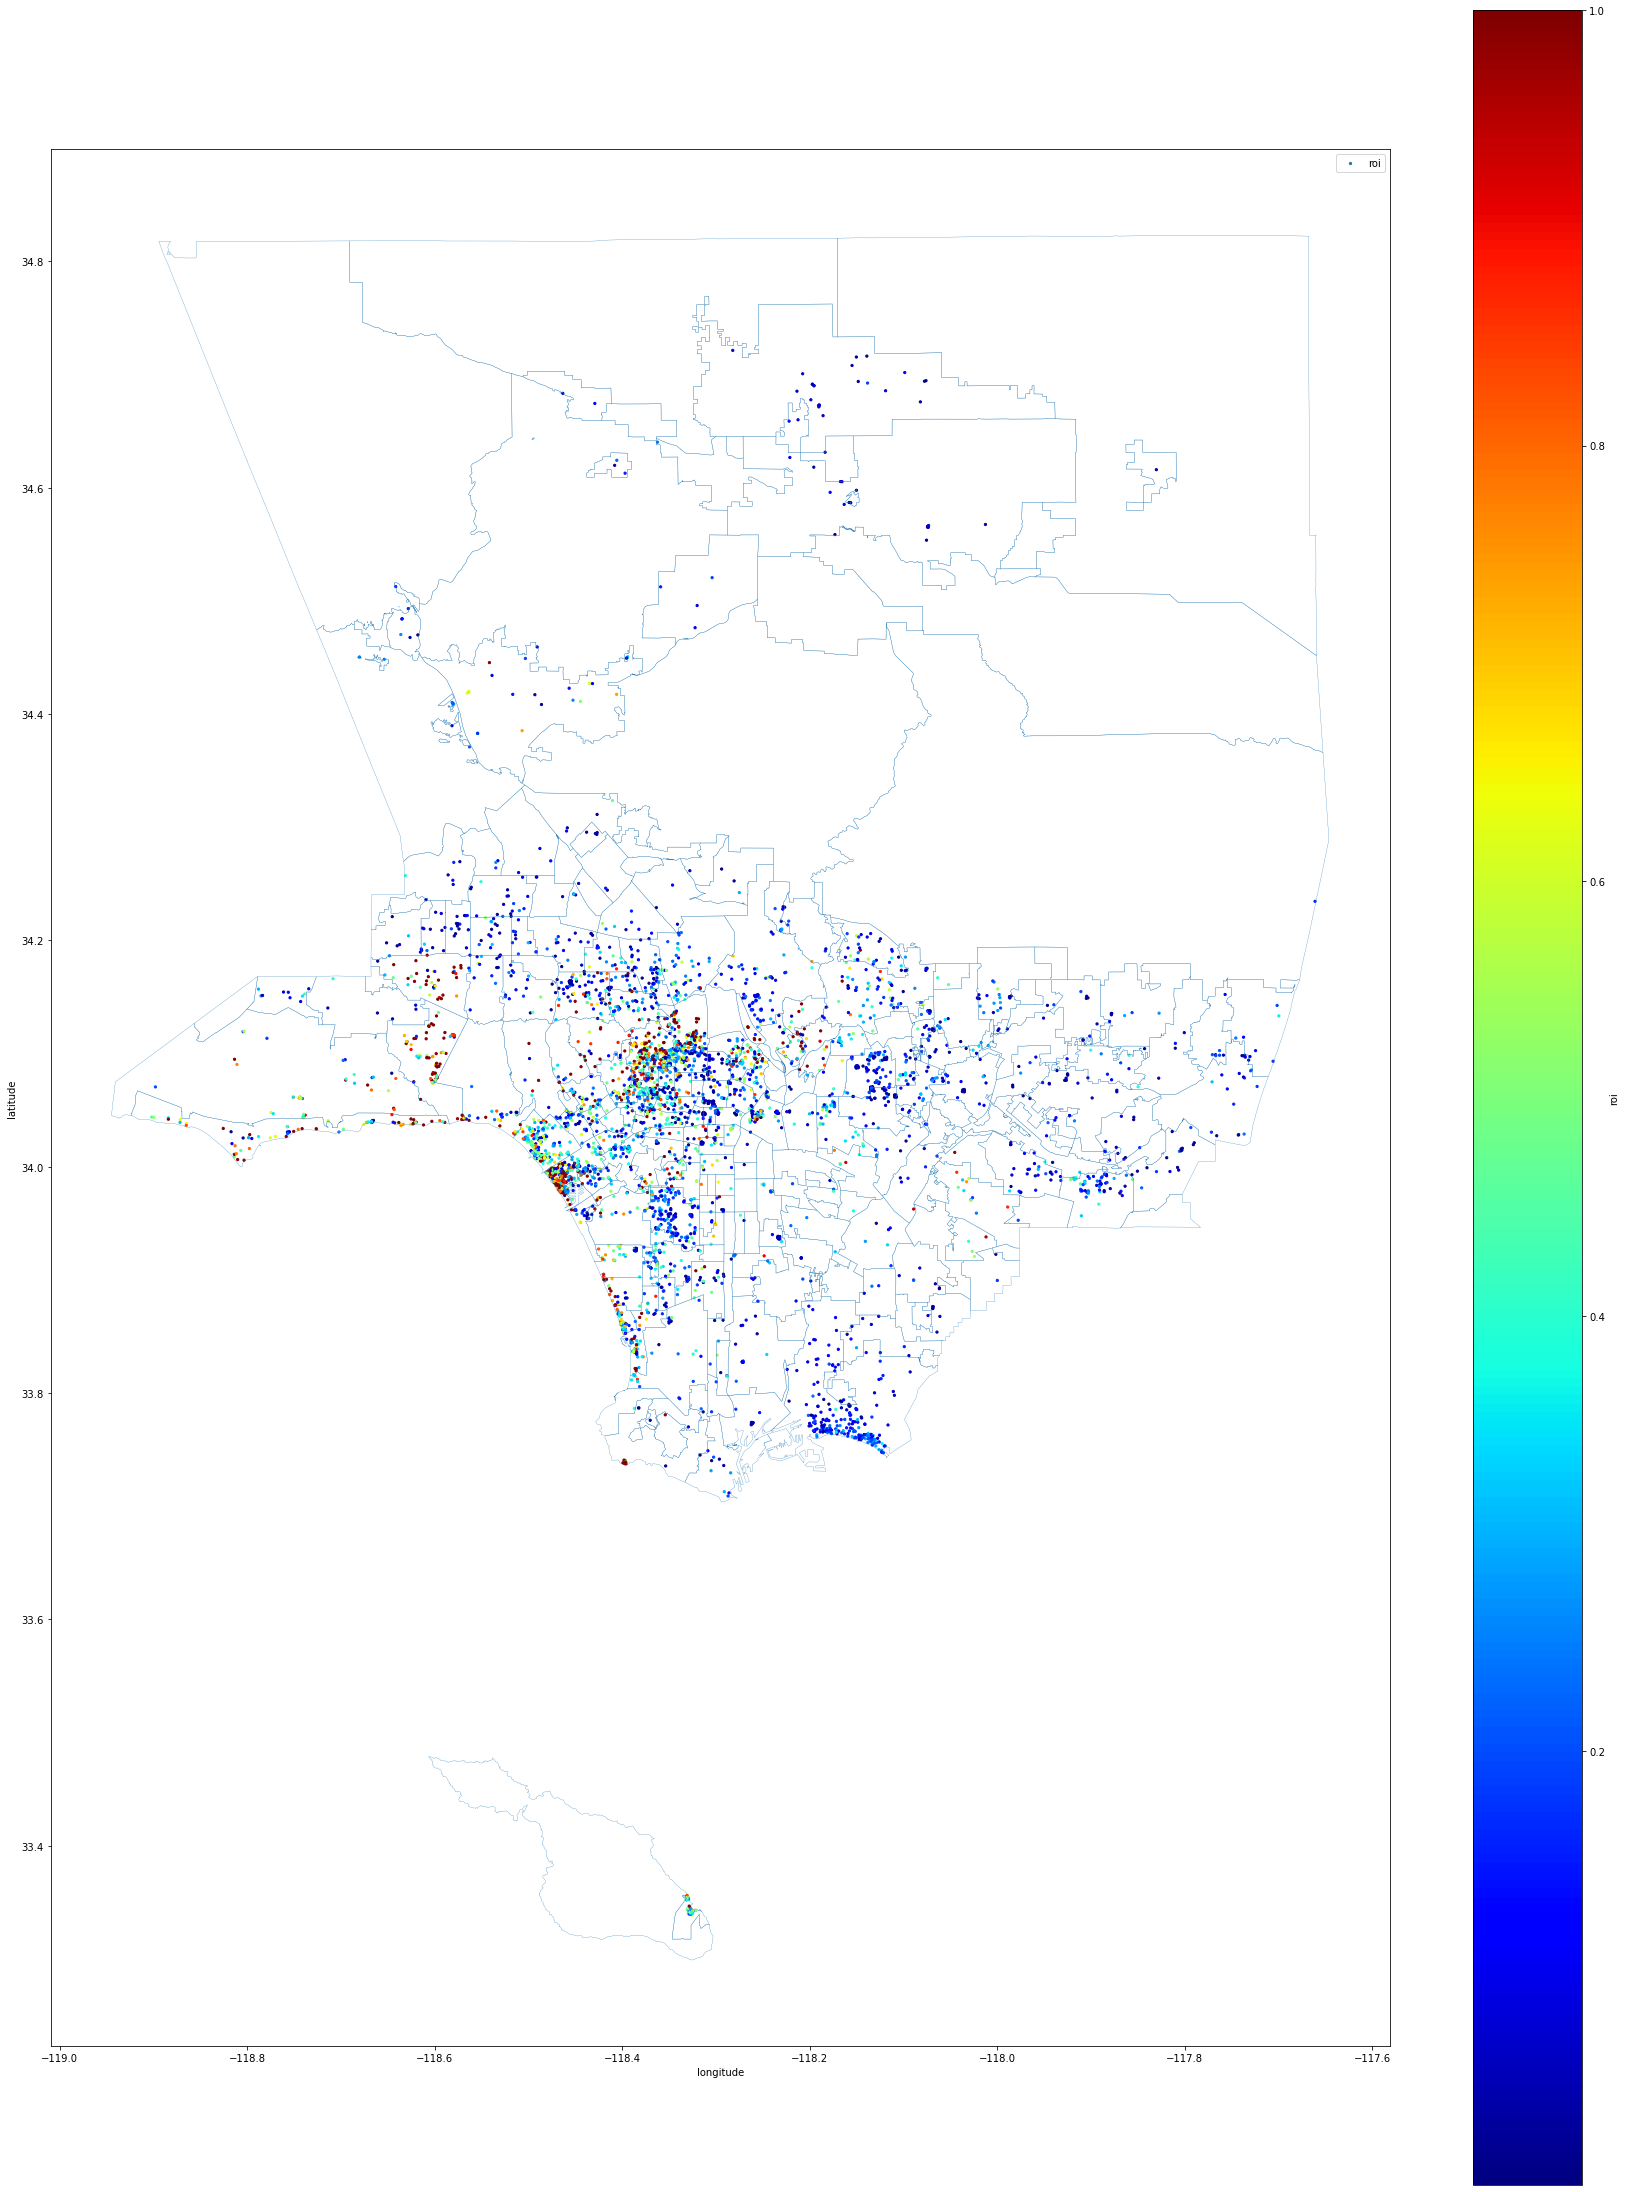

In [369]:
la_map = gpd.read_file('Data/neighbourhoods.geojson')
df['roi'][df['roi']>1]=1
plt.figure(figsize=(30,40))
ax = la_map.boundary.plot(linewidth = 0.25)
ax.set_facecolor("white")
df.plot(kind='scatter', x='longitude', y='latitude', label='roi', c='roi',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=1, s=  5, figsize=(30,40), ax=ax)

plt.legend()
plt.savefig('pdp.png')

Pricing Model

In [478]:
prange = np.arange(10, 50, 1)

In [436]:
prange

array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199])

In [482]:
pred_roi = []
for x in prange:
    p = X_train.iloc[2:3,:]
    p['price_per_person'] = x
    pred_roi.append(xgb_search.best_estimator_.predict(p)[0]*x*6*365/p['housing_price'])

Text(0, 0.5, 'Expected ROI')

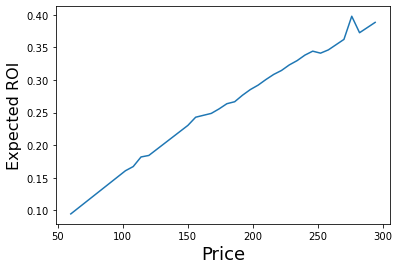

In [483]:
plt.plot(prange*6, pred_roi)
plt.xlabel('Price', fontsize=18)
plt.ylabel('Expected ROI', fontsize=16)

In [470]:
y_train

2307    0.683333
3639    0.500000
2045    0.908333
4059    0.166667
3523    0.750000
          ...   
3444    0.291667
466     0.466667
3092    0.525000
3772    0.050000
860     0.791667
Name: demand, Length: 3851, dtype: float64

In [471]:
xgb_search.best_estimator_.predict(X_train)

array([0.6652729 , 0.45005897, 0.85939234, ..., 0.5916643 , 0.2573481 ,
       0.7697724 ], dtype=float32)